# Assignment 2

**Credits**: Andrea Galassi, Federico Ruggeri, Paolo Torroni

**Keywords**: Transformers, Question Answering, CoQA

## List of tasks

### [Task 1] Remove unaswerable QA pairs 

Write your own script to remove unaswerable QA pairs from both train and validation sets. 

### [Task 2] Train, Validation and Test splits

CoQA only provides a train and validation set since the test set is hidden for evaluation purposes.

We'll consider the provided validation set as a test set. <br>
$\rightarrow$ Write your own script to:
* Split the train data in train and validation splits (80% train and 20% val)
* Perform splits such that a dialogue appears in one split only! (i.e., split at dialogue level)
* Perform splitting using the following seed for reproducibility: 42

#### Reproducibility Memo

Check back tutorial 2 on how to fix a specific random seed for reproducibility!

### [Task 3] Model definition

Write your own script to define the following transformer-based models from [huggingface](https://HuggingFace.co/).

* [M1] DistilRoBERTa (distilberta-base)
* [M2] BERTTiny (bert-tiny)

**Note**: Remember to install the ```transformers``` python package!

**Note**: We consider small transformer models for computational reasons!

### [Task 4] Question generation with text passage $P$ and question $Q$

We want to define $f_\theta(P, Q)$. 

Write your own script to implement $f_\theta$ for each model: M1 and M2.

#### Formulation

Consider a dialogue on text passage $P$. 

For each question $Q_i$ at dialogue turn $i$, your model should take $P$ and $Q_i$ and generate $A_i$.

### [Task 5] Question generation with text passage $P$, question $Q$ and dialogue history $H$

We want to define $f_\theta(P, Q, H)$. Write your own script to implement $f_\theta$ for each model: M1 and M2.

#### Formulation

Consider a dialogue on text passage $P$. 

For each question $Q_i$ at dialogue turn $i$, your model should take $P$, $Q_i$, and $H = \{ Q_0, A_0, \dots, Q_{i-1}, A_{i-1} \}$ to generate $A_i$.

### [Task 6] Train and evaluate $f_\theta(P, Q)$ and $f_\theta(P, Q, H)$

Write your own script to train and evaluate your $f_\theta(P, Q)$ and $f_\theta(P, Q, H)$ models.

### Instructions

* Perform multiple train/evaluation seed runs: [42, 2022, 1337].$^1$
* Evaluate your models with the following metrics: SQUAD F1-score.$^2$
* Fine-tune each transformer-based models for **3 epochs**.
* Report evaluation SQUAD F1-score computed on the validation and test sets.

$^1$ Remember what we said about code reproducibility in Tutorial 2!

$^2$ You can use ```allennlp``` python package for a quick implementation of SQUAD F1-score: ```from allennlp_models.rc.tools import squad```. 

### [Task 7] Error Analysis

Perform a simple and short error analysis as follows:
* Group dialogues by ```source``` and report the worst 5 model errors for each source (w.r.t. SQUAD F1-score).
* Inspect observed results and try to provide some comments (e.g., do the models make errors when faced with a particular question type?)$^1$

$^1$ Check the [paper](https://arxiv.org/pdf/1808.07042.pdf) for some valuable information about question/answer types (e.g., Table 6, Table 8) 

## Info for running this notebook

From now on you will find the code that we used to train the model, collect the results and do our comments, but if you simply want to check the f1 score and the final results of all the model you can directly go to the "*Compute squad f1 score [TASK 6 b, TASK 7]*" section and import the specified files from our Google Drive shared folder.

You will find all the weigths for all the trained models in the same Google Drive folder.
- In order to make the files accessible from colab you should add the folder to your Google Drive.
- The link to the shared folder is: 

## Create the dataframe, inspect the data and do some preprocessing [TASK 1, TASK 2]

### Download the dataset

In [2]:
import os
import os.path
import json
import typing
import urllib.request
import random
import pickle

import keras.callbacks
import keras.layers
import keras.losses
import keras.optimizers
import keras.regularizers
import numpy as np
import pandas as pd
import tensorflow as tf
from tqdm import tqdm

In [3]:
class DownloadProgressBar(tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)
        
def download_url(url, output_path):
    with DownloadProgressBar(unit='B', unit_scale=True,
                             miniters=1, desc=url.split('/')[-1]) as t:
        urllib.request.urlretrieve(url, filename=output_path, reporthook=t.update_to)

def download_data(data_path, url_path, suffix):    
    if not os.path.exists(data_path):
        os.makedirs(data_path)
        
    data_path = os.path.join(data_path, f'{suffix}.json')

    if not os.path.exists(data_path):
        print(f"Downloading CoQA {suffix} data split... (it may take a while)")
        download_url(url=url_path, output_path=data_path)
        print("Download completed!")

In [4]:
# Train data
train_url = "https://nlp.stanford.edu/data/coqa/coqa-train-v1.0.json"
download_data(data_path='coqa', url_path=train_url, suffix='train')

# Test data
test_url = "https://nlp.stanford.edu/data/coqa/coqa-dev-v1.0.json"
download_data(data_path='coqa', url_path=test_url, suffix='test')  # <-- Why test? See next slides for an answer!

coqa-train-v1.0.json: 49.0MB [00:06, 8.04MB/s]                            


Download completed!


coqa-dev-v1.0.json: 9.09MB [00:01, 7.12MB/s]                            

Download completed!


### Manage the dataframe preprocessing

In [5]:
train_path = './coqa/train.json'
test_path = './coqa/test.json'

with open(train_path, 'r') as f:
    train_json = json.load(f)

with open(test_path, 'r') as f:
    test_json = json.load(f)


Given that the dataset is provided as a json file we decided to unpack it with a first rough operation creating a column of a DataFrame for each key of the dictionary.

In [6]:
df_train = pd.json_normalize(train_json['data'])
df_test = pd.json_normalize(test_json['data'])

df_train.head()

,source,id,filename,story,questions,answers,name
0,wikipedia,3zotghdk5ibi9cex97fepx7jetpso7,Vatican_Library.txt,"The Vatican Apostolic Library (), more commonl...",[{'input_text': 'When was the Vat formally ope...,"[{'span_start': 151, 'span_end': 179, 'span_te...",Vatican_Library.txt
1,cnn,3wj1oxy92agboo5nlq4r7bndc3t8a8,cnn_fe05c61a7e48461f7883cdec387567029614f07b.s...,New York (CNN) -- More than 80 Michael Jackson...,"[{'input_text': 'Where was the Auction held?',...","[{'span_start': 243, 'span_end': 284, 'span_te...",cnn_fe05c61a7e48461f7883cdec387567029614f07b.s...
2,gutenberg,3bdcf01ogxu7zdn9vlrbf2rqzwplyf,data/gutenberg/txt/Zane Grey___Riders of the P...,"CHAPTER VII. THE DAUGHTER OF WITHERSTEEN \n\n""...",[{'input_text': 'What did Venters call Lassite...,"[{'span_start': 841, 'span_end': 880, 'span_te...",data/gutenberg/txt/Zane Grey___Riders of the P...
3,cnn,3ewijtffvo7wwchw6rtyaf7mfwte0p,cnn_0c518067e0df811501e46b2e1cd1ce511f1645b7.s...,(CNN) -- The longest-running holiday special s...,"[{'input_text': 'Who is Rudolph's father?', 't...","[{'span_start': 500, 'span_end': 557, 'span_te...",cnn_0c518067e0df811501e46b2e1cd1ce511f1645b7.s...
4,gutenberg,3urfvvm165iantk80llvkwwbjs7uzh,data/gutenberg/txt/Rafael Sabatini___Love-at-A...,CHAPTER XXIV. THE INTERRUPTED MASS \n\nThe mor...,"[{'input_text': 'Who arrived at the church?', ...","[{'span_start': 254, 'span_end': 297, 'span_te...",data/gutenberg/txt/Rafael Sabatini___Love-at-A...


As we can see, the sources for the dialogues are only five and they provide almost the same number of dialogues, apart from 'mctest'.

In [7]:
df_train['source'].value_counts()

race         1711
cnn          1702
wikipedia    1621
gutenberg    1615
mctest        550
Name: source, dtype: int64

We can also explore the number of dialogues and the average lenght of question-answer pairs for the training set.

In [8]:
print(f"- The training set contains {len(df_train)} dialogues.\n")
print(f"- On average we have {round(df_train['questions'].apply(lambda x: len(x)).mean(),2)}"
      f" question-answer pairs for each dialogue.")

- The training set contains 7199 dialogues.

- On average we have 15.09 question-answer pairs for each dialogue.


In the dataset above we have some features that are not useful for our task therefore we decided to remove them and we keep the story for each dialogue, the questions and the relative answers.

In [9]:
features_to_remove = ['source', 'id', 'filename', 'name']
features_to_remove_test = features_to_remove + [f'additional_answers.{i}' for i in range(3)]

df_train.drop(features_to_remove, axis=1, inplace=True)
df_test.drop(features_to_remove_test, axis=1, inplace=True)

In [10]:
df_train.head()

,story,questions,answers
0,"The Vatican Apostolic Library (), more commonl...",[{'input_text': 'When was the Vat formally ope...,"[{'span_start': 151, 'span_end': 179, 'span_te..."
1,New York (CNN) -- More than 80 Michael Jackson...,"[{'input_text': 'Where was the Auction held?',...","[{'span_start': 243, 'span_end': 284, 'span_te..."
2,"CHAPTER VII. THE DAUGHTER OF WITHERSTEEN \n\n""...",[{'input_text': 'What did Venters call Lassite...,"[{'span_start': 841, 'span_end': 880, 'span_te..."
3,(CNN) -- The longest-running holiday special s...,"[{'input_text': 'Who is Rudolph's father?', 't...","[{'span_start': 500, 'span_end': 557, 'span_te..."
4,CHAPTER XXIV. THE INTERRUPTED MASS \n\nThe mor...,"[{'input_text': 'Who arrived at the church?', ...","[{'span_start': 254, 'span_end': 297, 'span_te..."


At this point we can split the dataset in training and validation as stated in the assignment, we do that operation here because the questions are still grouped in dialogues therefore we put all the questions from one dialogue either in validation or in the training set, as specified in ***Task 2***.

In [11]:
seeds = [42, 2022, 1337]

def set_reproducibility(seed):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

In [12]:
def split_train_validation(df: pd.DataFrame, val_size: float=0.2) -> typing.Tuple[pd.DataFrame, pd.DataFrame]:
    '''
        It takes as input a dataframe and it splits it in 2 dataframes considering the 
        'val_size' parameter. 
    '''

    validation = df.sample(frac=val_size) 
    training = df.drop(validation.index)

    assert training is not None, "The dataframe is None"
    # It shuffles the training set dialogues
    training = training.sample(frac=1)

    return training.reset_index(drop=True), validation.reset_index(drop=True)

Before splitting the training data in training and validation set we set the seed 42 for the reproducibility as requested.

In [13]:
set_reproducibility(seeds[0])
df_train, df_val = split_train_validation(df_train, 0.2)
print(f"The dimensions of the datasets are:\n"
     f"Training dataset -> {df_train.shape} - Validation dataset -> {df_val.shape}")

The dimensions of the datasets are:
Training dataset -> (5759, 3) - Validation dataset -> (1440, 3)


We still have to unpack the array of questions and answers in order to create a row for each single element and we need to remove the unanswerable questions from the data.
- The first function is a helper that allows us to create different rows of a DataFrame from a list of questions. 
- The second one is used to remove the unanswerable questions from the data, a question is ***unanswerable*** if the 'span_start' feature is -1.

In [14]:
#@title #### Functions to unpack and remove unanswerable questions
def expand_lists(df: pd.DataFrame, to_drop: typing.List[str]=[],
                 for_eval: bool=False) -> pd.DataFrame:
    '''
        Given a Pandas dataframe it returns a new dataframe with the expansion of
        the questions and the answers and removing the desired columns.
    '''
    if for_eval:
        # Add also the 'source' feature
        assert 'source' in df.columns, "The DataFrame has not the 'source' feature"
        questions = [{'source': df.source[i], 'story':df.story[i], **quest} 
                        for i, lis in enumerate(df.questions) for quest in lis]
    else:
        # Create a dictionary with the story and the other features for each question
        questions = [{'story':df.story[i], **quest} for i, lis in enumerate(df.questions) for quest in lis]

    answers = [ans for lis in df.answers for ans in lis]

    # Create a DataFrame from the previous dictionaries and remove useless features
    X = pd.DataFrame.from_dict(questions, orient="columns").drop(to_drop, axis=1)
    y = pd.DataFrame.from_dict(answers, orient="columns").drop(to_drop, axis=1)

    assert X is not None and y is not None, "The dataframe is None"
    
    X.rename(columns={'input_text':'questions'}, inplace=True)
    y.rename(columns={'input_text':'answers'}, inplace=True)
    
    return pd.concat([X, y], axis=1)


def remove_unanswerable(df: pd.DataFrame, df_name: str, verbose:bool=True) -> pd.DataFrame:
    '''
        It removes the unanswerable questions from the passed DataFrame
        removing the elements with 'span_start' < 0
    '''

    target = 'span_start'
    if target not in df.columns:
        print(
            "WARNING: the DataFrame doesn't have the 'span_start' column, the"
            " function will return the DataFrame without changes."
            )
        return df
        
    uns_rows = df[target] > 0
    if verbose:
        print(
            f"{len(df) - len(df[uns_rows])} unanswerable questions have been removed"
            f" from the {df_name} DataFrame."
            )
    return df[uns_rows].reset_index(drop=True)

In order to make the code as ordered as possible we implemented a unique function for the preprocessing that we need to apply on the different DataFrames. It simply calls the 2 previous functions on the passed DataFrame, it removes the features about the spans and it returns the new DataFrame.

In [15]:
def data_preprocessing(df: pd.DataFrame, df_name: str, to_drop: typing.List[str]=[],
                       for_eval: bool=False) -> pd.DataFrame:
    '''
        This function creates a DataFrame with a column for the 'story', one
        for the 'questions' and another for the 'answers' and it removes the
        unanswerable questions.
        Parameters:
            - df : pd.DataFrame
                The structure on which performing the operations.
            - to_drop: list[str]
                The names of the columns to drop.
            - for_eval: bool
                If the expand_lists function has to be run in evaluation mode,
                so we preserve the 'source' feature.
                
        Returns:
            pandas.Dataframe
                The modified dataframe.
    '''
    new_df = expand_lists(df, to_drop, for_eval)
    new_df = remove_unanswerable(new_df, df_name)

    span_feat = ['span_start', 'span_end', 'span_text']
    new_df.drop(span_feat, axis=1, inplace=True)

    return new_df

In [16]:
df_train = data_preprocessing(df_train, df_name="training", to_drop=['turn_id', 'bad_turn'])
df_val = data_preprocessing(df_val, df_name="validation", to_drop=['turn_id', 'bad_turn'])
df_test = data_preprocessing(df_test, df_name="test", to_drop=['turn_id'])

print(f"\nThe training set has {len(df_train)} samples, the validation set has {len(df_val)} samples"
      f" and the test set has {len(df_test)} samples.")

3490 unanswerable questions have been removed from the training DataFrame.
900 unanswerable questions have been removed from the validation DataFrame.
288 unanswerable questions have been removed from the test DataFrame.

The training set has 83408 samples, the validation set has 20849 samples and the test set has 7695 samples.


At this moment the DataFrame looks like this:

In [17]:
df_train.head()

,story,questions,answers
0,CHAPTER III. \n\nTHE NIGHT-WATCHERS. \n\nWhat ...,What color is the top of the church?,green
1,CHAPTER III. \n\nTHE NIGHT-WATCHERS. \n\nWhat ...,Is it short?,No
2,CHAPTER III. \n\nTHE NIGHT-WATCHERS. \n\nWhat ...,Who behaves better?,the back of the Tenements
3,CHAPTER III. \n\nTHE NIGHT-WATCHERS. \n\nWhat ...,Why?,Every back window in the Tenements has a glint...
4,CHAPTER III. \n\nTHE NIGHT-WATCHERS. \n\nWhat ...,Who killed himself?,Beattie


## Model implementation and data tokenization [TASK 3, TASK 4, TASK 5]

In order to train the encoder-decoder architecture we have to tokenize the samples such that we can give numbers as input to the network.

In our case we will use the tokenizer of the relative pre-trained models because distilroberta and bert-tiny do the tokenization in 2 different ways.

In [19]:
!pip install transformers -q
!pip install datasets -q
import datasets

     |████████████████████████████████| 5.8 MB 22.5 MB/s 
     |████████████████████████████████| 182 kB 56.1 MB/s 
     |████████████████████████████████| 7.6 MB 53.3 MB/s 
     |████████████████████████████████| 451 kB 33.3 MB/s 
     |████████████████████████████████| 212 kB 60.7 MB/s 
     |████████████████████████████████| 132 kB 49.5 MB/s 
     |████████████████████████████████| 127 kB 78.6 MB/s 


### Load the pre-trained model and tokenizer either from Huggingface or Drive

In this section you can choose to import from Huggingface a new instance of the pretrained models (in order to fine-tune it) or to load our fine-tuned models from the Drive folder.

In [20]:
from typing import Optional, Union, List, Tuple, Dict

from datasets.arrow_dataset import Dataset
from transformers import TFEncoderDecoderModel, AutoTokenizer

from keras.optimizers import Adam

In [21]:
from google.colab import drive
drive.mount('/content/drive')

drive_weights_path = "/content/drive/MyDrive/weights_NLP_assignments/"
drive_tokenized_path = "/content/drive/MyDrive/weights_NLP_assignments/tok_data/"

bertiny_name = "prajjwal1/bert-tiny"
roberta_name = "distilroberta-base"

Mounted at /content/drive


We implemented a function to import the tokenizer and the model from a pre-saved model or directly from Huggingface if no path is passed. 

Choosing the options from the dropdown with the original model names the function will import the pretrained model from Huggingface, otherwise it will load the fine-tuned model from Drive and it will download the tokenizer from Huggingface.

In [22]:
from IPython.display import display

#@title #### Functions to import the models and get the list of available ones from Drive
def check_pretrained_path(path: str) -> bool:
    '''
        It checks if the config.json file exists in the current path.
    '''
    config_file = os.path.join(path, 'config.json')
    return os.path.exists(config_file)


def import_model_tokenizer(name: str="distilroberta-base", load_weights: Optional[str]=None)->tuple:
    '''
        It imports the tokenizer and the model specified from the 'name' parameter.
        If a path in 'load_weigths' is specified then it imports the model from
        a pre-saved file.
        Parameters:
            - name: str
                The name of the model we want to import, it must exist in the
                Huggingface database.
            - load_weights: str | None
                The path to a directory that contains the config file and the 
                .h5 file for loading a pre-saved model.
        
        Returns:
            - tuple
                It returns the desired tokenizer and the imported model.
    '''
    tokenizer = AutoTokenizer.from_pretrained(name)
    enc_from_pt = False

    # If a path has been passed
    if load_weights != None:
        mod_name = name.split('/')[-1]
        full_path = os.path.join(drive_weights_path, mod_name, load_weights)
        if check_pretrained_path(full_path):
            model = TFEncoderDecoderModel.from_pretrained(full_path)
        else:
            print("ERROR: Check if a config.json file exists in the given path.")
            return None, None
    else:
        if name != "distilroberta-base":
            enc_from_pt = True

        model = TFEncoderDecoderModel.from_encoder_decoder_pretrained(
            name, name, encoder_from_pt=enc_from_pt, decoder_from_pt=enc_from_pt
        )
        model.config.decoder_start_token_id = tokenizer.cls_token_id
        model.config.pad_token_id = tokenizer.pad_token_id
        model.config_eos_token_id = tokenizer.sep_token_id
        model.config.vocab_size = model.config.encoder.vocab_size

    return tokenizer, model



def retrieve_available_models(path=None):
    ''' 
        It lists all the available models in the Drive folder.
    '''
    if path is None:
        bert_path = os.path.join(drive_weights_path, bertiny_name.split('/')[-1])
        roberta_path = os.path.join(drive_weights_path, roberta_name)
        paths = [bert_path, roberta_path]
    else:
        paths = [path]

    models = [(bertiny_name+' (not fine-tuned)', bertiny_name), (roberta_name+' (not fine-tuned)', roberta_name)]
    for p in paths:
        if os.path.exists(p):
            for mod in os.listdir(p):
                # Return the name of the model and the path where it is
                name = p.split('/')[-1]
                models.append((os.path.join(name, mod), os.path.join(p, mod)))
        else:
            print(f"ERROR: the path {p} doesn't exist or is not available.")
    return models


def choose_model(btn, out_box, model_sel): 
    '''
        It imports the selected model and tokenizer, from Drive or Huggingface 
        once the button is clicked.
    '''
    # Load the desired model
    path = model_sel.value
    tok_name = bertiny_name if 'bert-tiny' in path else roberta_name

    load_weights = None if path == bertiny_name or path == roberta_name else path
    use_history = 'no_history' if 'no_history' in path else 'history'
    config = {'mod_name': tok_name.split('/')[-1], 'history': use_history}

    with out_box:
        out_box.clear_output()
        print('\nImporting the selected model and the relative tokenizer ...\n')
        tokenizer, model = import_model_tokenizer(tok_name, load_weights=load_weights)

        btn.imported_model = model
        btn.imported_tokenizer = tokenizer
        btn.load_config = config
        print('\nThe model and the tokenizer have been saved successfully!')

In [23]:
import ipywidgets as widgets
from ipywidgets import interact, Layout, Button, VBox, Output
import functools

#@title #### Select the model 
available_models = retrieve_available_models()
out_box = Output()

model_sel = widgets.Dropdown(
    options=available_models,
    description='<font size=3>Choose the desired model to import (and the relative tokenizer):</font>',
)
model_sel.layout = Layout(width='50%', height = '40px')
model_sel.style = {'description_width': 'initial'}

confirm_btn = Button(description='Confirm model', style={'font_weight': '600'})
confirm_btn.on_click(functools.partial(choose_model, out_box=out_box, model_sel=model_sel))

box = VBox([model_sel, confirm_btn])

display(box)
display(out_box)

Output()

In [ ]:
try:
    model = confirm_btn.imported_model
    tokenizer = confirm_btn.imported_tokenizer
    load_config = confirm_btn.load_config
except:
    print("ERROR: you have to select a model in the previous cell.")

### Tokenization function and history creation

The following function is needed to create the history for each sample, the history is composed by the 'story' of the question and all the questions and answers from the previous rows.
The function has 3 main steps:
- we group by 'story' in order to consider the samples belonging to the same dialogue; we create a new column 'history' in the DataFrame where we put for each line the concatenation of answer and question of the previous row. This because the first element of the history for each question is the previous one, so we need to shift by 1 such that we avoid to put the current question and answer in the history as well.
- Now, after having grouped by 'story' again, we apply the function *cumulative sum*, it sums the previous rows of the same group to the current one.
- As last step we sum the 'story' to the computed history and we return the DataFrame with the new column.

In [25]:
#@title #### Function to create history
def create_history(df: pd.DataFrame, group: str='story') -> pd.DataFrame:
    '''
        This function returns the dataframe with a new column 'history' which
        contains the sum of the story and all the questions and answers within
        the same context, not considering the current sample.
        Parameters:
            - df: pd.DataFrame
                The dataframe from which the function takes the data.
            - group: str
                The column to consider for the groupby operation.
        
        Returns:
            - pd.DataFrame
                The DataFrame with the new column added. 
    '''
    new_df = df.copy()
    sum_columns = lambda x: x.questions + ' ' + x.answers + ' '
    # If the story has a white space at the end, we don't need to add it
    def sum_ctx_history(row):
        space = " "
        if row.story[-1].isspace():
            space = ""
        return row.story + space + row.history

    # Returns a new column that contains for each sample the sum of the
    # question and the context
    new_df['history'] = new_df.groupby(group, axis=0, sort=False) \
                            .shift(fill_value='') \
                            .apply(sum_columns, axis=1)

    # Sum the history up to the previous question for each sample
    new_df['history'] = new_df.groupby(group, axis=0, sort=False)['history'] \
                            .apply(lambda x: x.cumsum()).str.strip()

    new_df['history'] = new_df.apply(sum_ctx_history, axis=1)

    print("The column for the history has been added to the dataset.")
    return new_df

The following functions are used to compute the tokenized answers and the tokenization for each question plus the relative context (story / history). The function has a parameter that checks if the history needs to be created, if this is the case the previous function 'create_history' is called and the successive operations are performed with the new dataset.

We decided to create batch of samples from the passed dataset in order to avoid the consumption of the RAM, even if we also give the possibiity to save the tokenized data in a .pkl file in the Drive directory, to make the data load faster.   

In [26]:
#@title #### Function to tokenize the samples 
def apply_reduce(data, func):
    '''
        Apply the function on a list of elements concatenating the samples with 
        the previous results (as the reduce).
    '''
    res = data.pop(0)
    for el in data:
        res = func((res, el))
    return res

def tokenize_samples(dataset: datasets.arrow_dataset.Dataset, tokenizer, max_embed_quest: int=512,
                     max_embed_answ: int=30, mode: Optional[str]='np', with_history: bool=False, 
                     batch_size: int=1024)->tuple:
    '''
        This function returns a dictionary with the outputs of the tokenizer.
        As input we refer to the concatenation of the quesions with the relative
        contexts and we need both tokenization and attention mask. For the
        answers we only need the tokenization.
        Parameters:
            - dataset: datasets.arrow_dataset.Dataset
                The dataset from which the function takes the data.
            - max_embed_quest: int
                The maximum length for the sequence context + questions, in our 
                case is 512.
            - max_embed_answ: int
                The maximum length for the tokenized answers.
            - mode: bool
                Wheter the tokenizer could return the outputs as lists of python
                integers, 'tf' tensors, 'np' arrays or 'pt' for pytorch tensors.
            - with_history: bool
                If True then we concatenate the question with the history instead 
                of the simple context.
            - batch_size: int
                The batch size to use in for computing the tokenization.
                
        Returns:
            - tuple
                A tuple with the tokenized questions+contexts, their relative
                attention masks and the tokenized answers.
                If 'with_history' is True it also returns the new dataset
                with the history, the passed dataset otherwise.
    '''
    if with_history:
        pandas_dataset = dataset.to_pandas()
        assert isinstance(pandas_dataset, pd.DataFrame)

        new_dataset = Dataset.from_pandas(create_history(pandas_dataset))
        context = new_dataset["history"]
    else:
        new_dataset = dataset
        context = dataset['story']

    ids = []
    masks = []
    ys = []

    num_steps = len(new_dataset) // batch_size
    last_batch_size = len(new_dataset) - (batch_size*num_steps)

    print("Tokenization begins ...\n")
    for i in tqdm(range(num_steps+1)):
        start = batch_size * i
        # If we are in the last batch and it's > 0
        if i >= num_steps:
            if last_batch_size > 0:
                batch_size = last_batch_size
            else:
                break

        # Take a batch of samples
        batch_quest = new_dataset['questions'][start:start+batch_size]
        batch_ctx = context[start:start+batch_size]
        batch_answ = new_dataset['answers'][start:start+batch_size]
        
        # Tokenize the batch
        x_tok_batch = tokenizer(
            batch_quest,
            batch_ctx,
            max_length=max_embed_quest,
            truncation="only_second",
            padding="max_length",
            return_tensors=mode,
            return_token_type_ids=False
        )
        y_tok_batch = tokenizer(
            batch_answ,
            max_length=max_embed_answ,
            truncation=True,
            padding="max_length",
            return_tensors=mode,
            return_token_type_ids=False
        )
        # Create 3 lists for the results
        ids.append(x_tok_batch['input_ids'])
        masks.append(x_tok_batch['attention_mask'])
        ys.append(y_tok_batch['input_ids'])
    
    # Merge the results of the different batches concatenating them
    X_tok = {'input_ids': apply_reduce(ids, np.concatenate), 
             'attention_mask': apply_reduce(masks, np.concatenate)}
    y_tok = apply_reduce(ys, np.concatenate)
    
    return X_tok, y_tok, new_dataset

### Tokenize the data or load it

Actually before tokenization occurs we create the [Dataset objects](https://huggingface.co/docs/datasets/v1.11.0/index.html) (Huggingface) from the DataFrames. Then the tokenization function returns as result a dictionary of numpy array ('input_ids' and 'attention_mask') that is used as input for the model and a numpy array for the tokenized answers.

In [29]:
dataset_train = Dataset.from_pandas(df_train)
dataset_val = Dataset.from_pandas(df_val)
dataset_test = Dataset.from_pandas(df_test)

The following 2 subsections are needed to perform the tokenization.
- *Load saved tokenized data*: to load the already tokenized data from Google Drive.
- *Compute tokenization*: to tokenize the dataset (computationally expensive, ~1min 30s).

NOTE: execute only one section to avoid overwriting the variables.

#### Load pre-saved tokenized data

The tokenized data are loaded from pickle files, one for training, validation and test.
They are different for the chosen model (e.g. bert-tiny with history).

These files contain:
- 'input_ids': the tokenization of the concatenation of the answer and the story (or history if selected).
- 'attention_mask': the attention masks for the input_ids.
- 'labels': the target arrays that represent the tokenized answers.


In [30]:
def load_tokenized_dict(file_path: str) -> Union[Tuple[Dict, np.ndarray], Tuple[None, None]]:
    '''
        It load the .pkl file from the given path, it convert the lists to numpy
        arrays and at the end it returns a dictionary with 'input_ids' and 
        'attention_mask' and the array of the tokenized answers.
        Parameters:
            - file_path: str
                The path of the .pkl file from which we read the data.
            
        Returns:
            - Tuple[Dict[np.ndarray, np.ndarray], np.ndarray] | Tuple[None, None]
                A tuple, the dictionary with the 'input_ids' and the 'attention_mask'
                numpy arrays if the path exists, None otherwise.
    '''
    if os.path.exists(file_path):
        with open(file_path, 'rb') as handle:
            data = pickle.load(handle)

        y_labels = data['labels']
        del data['labels']

        return data, y_labels 
    else:
        print(f"ERROR: a file doesn't exist in the specified path: {file_path}.")
        return None, None

In [31]:
#  Import the tokenized data from the pkl files (the correct file considered the previously imported model)
load_dir = load_config['history']
is_hist = '_hist' if load_dir=='history' else ''
model_name = load_config['mod_name']

x_train, y_train = load_tokenized_dict(os.path.join(
                    drive_tokenized_path, load_dir, model_name, f'train_tok{is_hist}.pkl'))

x_val, y_val = load_tokenized_dict(os.path.join(
                    drive_tokenized_path, load_dir, model_name, f'val_tok{is_hist}.pkl'))

x_test, y_test = load_tokenized_dict(os.path.join(
                    drive_tokenized_path, load_dir, model_name, f'test_tok{is_hist}.pkl'))


#### Compute tokenization 

In [ ]:
# Compute the tokenized data, if you specify a different dimension, only on a subset
# of the dataset.
train_samples = len(dataset_train)
val_samples = len(dataset_val)
history = True

x_train, y_train, hist_train_dataset = tokenize_samples(
    dataset_train.select(range(train_samples)),
    tokenizer, with_history=history, batch_size=16384
    )

x_val, y_val, hist_val_dataset = tokenize_samples(
    dataset_val.select(range(val_samples)),
    tokenizer, with_history=history, batch_size=4096
    )

x_test, y_test, hist_test_dataset = tokenize_samples(
    dataset_test, tokenizer, with_history=history, batch_size=1024
    )

##### Save tokenized data in .json

In [ ]:
def save_tokenized_dict(x_data: dict, y_data: np.ndarray, file_path: str='./tokenized.pkl'):
    '''
        It saves the given data, a dictionary with 'input_ids' and 
        'attention_mask', as a .pkl file in the given_path. The values in the
        x_data needs to be numpy arrays otherwise an error is raised due to the
        'tolist()' function. 
        Parameters:
            - x_data: dict
                The dictionary that contains 'input_ids' and 'attention_mask'.
            - y_data: np.ndarray
                The array of tokenized answers.
            - file_path: str
                The path where the file will be saved.
    '''
    data = {**x_data, 'labels': y_data}
    with open(file_path, 'wb') as handle:
        pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
save_to = 'history'
is_history_save = '_hist' if save_to=='history' else ''
model_name = bertiny_name.split('/')[-1] #roberta_name

save_tokenized_dict(
    x_train, y_train, 
    os.path.join(drive_tokenized_path, save_to, model_name, f'train_tok{is_history_save}.pkl')
    )

save_tokenized_dict(
    x_val, y_val,
    os.path.join(drive_tokenized_path, save_to, model_name, f'val_tok{is_history_save}.pkl')
    )

save_tokenized_dict(
    x_test, y_test, 
    os.path.join(drive_tokenized_path, save_to, model_name, f'test_tok{is_history_save}.pkl')
    )

## Train the models [TASK 6 a]

In [ ]:
#@title #### Simple training function
def train_model(model: TFEncoderDecoderModel, X_train: dict, y_train: np.ndarray, epochs: int=3,
                batch_size: int=32, optimizer: keras.optimizers.Optimizer=Adam(1e-5),
                X_val: Optional[dict]=None, y_val: Optional[dict]=None) -> keras.callbacks.History:
    '''
        It trains the given model for the specified number of epochs, the given
        optimizer and the given batch. It returns the history
        Parameters:
            - model: TFEncoderDecoderModel
                The encoder decoder model to train on the data.
            - X_train: dict
                The dictionary that contains 'input_ids' and 'attention_mask'
                arrays.
            - y_train: np.ndarray
                The array of the tokenized answers.
            - epochs: int
                The number of epochs to train the model for.
            - batch_size: int
                The batch size to use during the training.
            - optimizer: keras.optimizers.Optimizer
                The optimizer to consider for the training.
            - X_val: dict | None
                The X data for the validation dataset.
            - y_val: dict | None
                The y data for the validation dataset.
        
        Returns:
            - keras.callbacks.History
                The history of the training.
    '''
    validation_data = None if (X_val is None or y_val is None) else (X_val, y_val) 

    model.compile(optimizer=optim)

    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                        validation_data=validation_data)
    return history

- We only need to fine-tune the model on our data so we keep a low learning rate.
- Distilroberta models have a very heavy training therefore we decided to use only a small part of the training set to train them (10k samples) and a small batch size to avoid OOM error on Colab.

In [ ]:
#@title #### Utils functions for reducing the dataset and to plot the loss after training 
from matplotlib import pyplot as plt

def reduce_dataset(x: dict, y: np.ndarray, red_samples: int):
    '''
        It returns a smaller version of x and y taking only 'red_samples' samples.
    '''
    x_red = {
        'input_ids': x['input_ids'][:red_samples],
        'attention_mask': x['attention_mask'][:red_samples]
        }
    y_red = y[:red_samples]

    return x_red, y_red


def plot_loss(history, min_y, max_y):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.ylim(min_y, max_y)
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

In [ ]:
epochs = 3
lr=3e-5
optim = Adam(lr)

def prepare_and_start_training(model, x_train, y_train, x_val, y_val, seed_ind,
                               use_history, save=True):
    '''
        This function prepares the data (e.g. change dataset size if roberta), set
        the desired seed and saves the model weights if the parameter 'save' is true.
        It returns the history of the training of the model.
    '''
    curr_seed = seeds[seed_ind]
    set_reproducibility(curr_seed)

    # Reduce the batch size and number of samples to avoid OOM and too long training time
    if 'roberta' in model.config.encoder.name_or_path:
        red_train = 10000
        red_val = 2000
        batch_size = 16
        mod_name = roberta_name

        x_train_red, y_train_red = reduce_dataset(x_train, y_train, red_train)
        x_val_red, y_val_red = reduce_dataset(x_val, y_val, red_val)

        history = train_model(model, x_train_red, y_train_red, epochs, batch_size, optim, 
                        x_val_red, y_val_red)
    else:
        batch_size = 64
        history = train_model(model, x_train, y_train, epochs, batch_size, optim, 
                        x_val, y_val)
        mod_name = bertiny_name.split('/')[-1]

    if save:
        is_hist = 'history' if use_history else 'no_history'
        save_to = os.path.join(drive_weights_path, mod_name, f'{curr_seed}_{is_hist}')
        # Check if you really want to overwrite the weights
        if os.path.exists(save_to):
            permission = input(f"Do you want to overwrite {save_to}? [y/n]")
            if permission == 'y':
                model.save_pretrained(save_to)
            else:
                print("The model has not been saved as chosen.")
        else:
            model.save_pretrained(save_to)
    return history

### Bert-tiny models training

#### Bert-tiny seed 42

##### Without history

In [ ]:
history = prepare_and_start_training(model, x_train, y_train, x_val, y_val, 
                                     seed_ind=0, use_history=False, save=True)

No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


Epoch 1/3


/usr/local/lib/python3.8/dist-packages/tensorflow/python/autograph/impl/api.py:371: FutureWarning: Version v4.17.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.17.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  return py_builtins.overload_of(f)(*args)


1304/1304 [==============================] - 419s 310ms/step - loss: 1.1535 - val_loss: 0.7299
Epoch 2/3
1304/1304 [==============================] - 401s 308ms/step - loss: 0.7343 - val_loss: 0.6935
Epoch 3/3
1304/1304 [==============================] - 402s 308ms/step - loss: 0.6832 - val_loss: 0.6495


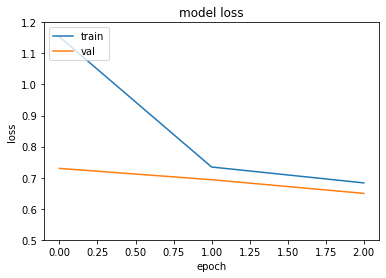

In [ ]:
plot_loss(history, 0.5, 1.2)

##### With history

In [ ]:
history = prepare_and_start_training(model, x_train, y_train, x_val, y_val, 
                                     seed_ind=0, use_history=True, save=True)

No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


Epoch 1/3


/usr/local/lib/python3.8/dist-packages/tensorflow/python/autograph/impl/api.py:371: FutureWarning: Version v4.17.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.17.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  return py_builtins.overload_of(f)(*args)


1304/1304 [==============================] - 415s 309ms/step - loss: 1.1537 - val_loss: 0.7306
Epoch 2/3
1304/1304 [==============================] - 401s 308ms/step - loss: 0.7348 - val_loss: 0.6957
Epoch 3/3
1304/1304 [==============================] - 401s 307ms/step - loss: 0.6855 - val_loss: 0.6504


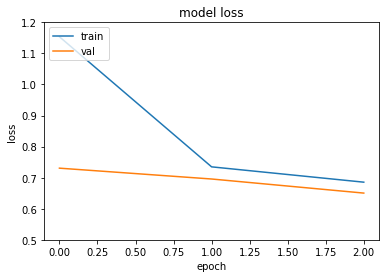

In [ ]:
plot_loss(history, 0.5, 1.2)

#### Bert-tiny seed 2022

##### Without history

In [ ]:
history = prepare_and_start_training(model, x_train, y_train, x_val, y_val, 
                                     seed_ind=1, use_history=False, save=True)

No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


Epoch 1/3


/usr/local/lib/python3.8/dist-packages/tensorflow/python/autograph/impl/api.py:371: FutureWarning: Version v4.17.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.17.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  return py_builtins.overload_of(f)(*args)


1304/1304 [==============================] - 417s 310ms/step - loss: 1.1506 - val_loss: 0.7294
Epoch 2/3
1304/1304 [==============================] - 402s 308ms/step - loss: 0.7341 - val_loss: 0.6933
Epoch 3/3
1304/1304 [==============================] - 402s 308ms/step - loss: 0.6831 - val_loss: 0.6502


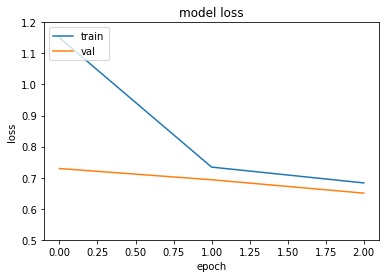

In [ ]:
plot_loss(history, 0.5, 1.2)

##### With history

In [ ]:
history = prepare_and_start_training(model, x_train, y_train, x_val, y_val, 
                                     seed_ind=1, use_history=True, save=True)

No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


Epoch 1/3


/usr/local/lib/python3.8/dist-packages/tensorflow/python/autograph/impl/api.py:371: FutureWarning: Version v4.17.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.17.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  return py_builtins.overload_of(f)(*args)


1304/1304 [==============================] - 427s 321ms/step - loss: 1.1508 - val_loss: 0.7302
Epoch 2/3
1304/1304 [==============================] - 414s 318ms/step - loss: 0.7345 - val_loss: 0.6957
Epoch 3/3
1304/1304 [==============================] - 405s 310ms/step - loss: 0.6861 - val_loss: 0.6510


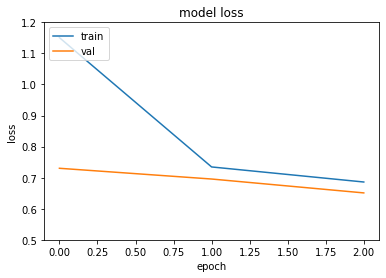

In [ ]:
plot_loss(history, 0.5, 1.2)

#### Bert-tiny seed 1337

##### Without history

In [ ]:
history = prepare_and_start_training(model, x_train, y_train, x_val, y_val, 
                                     seed_ind=2, use_history=False, save=True)

No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


Epoch 1/3


/usr/local/lib/python3.8/dist-packages/tensorflow/python/autograph/impl/api.py:371: FutureWarning: Version v4.17.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.17.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  return py_builtins.overload_of(f)(*args)


1304/1304 [==============================] - 414s 311ms/step - loss: 1.1522 - val_loss: 0.7280
Epoch 2/3
1304/1304 [==============================] - 403s 309ms/step - loss: 0.7345 - val_loss: 0.6940
Epoch 3/3
1304/1304 [==============================] - 403s 309ms/step - loss: 0.6846 - val_loss: 0.6502


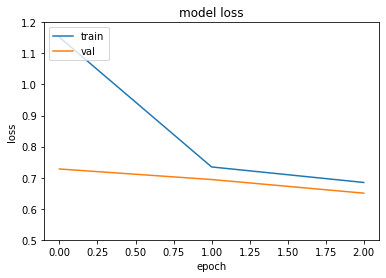

In [ ]:
plot_loss(history, 0.5, 1.2)

##### With history

In [ ]:
history = prepare_and_start_training(model, x_train, y_train, x_val, y_val, 
                                     seed_ind=2, use_history=True, save=True)

No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


Epoch 1/3


/usr/local/lib/python3.8/dist-packages/tensorflow/python/autograph/impl/api.py:371: FutureWarning: Version v4.17.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.17.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  return py_builtins.overload_of(f)(*args)


1304/1304 [==============================] - 413s 311ms/step - loss: 1.1524 - val_loss: 0.7289
Epoch 2/3
1304/1304 [==============================] - 402s 308ms/step - loss: 0.7349 - val_loss: 0.6960
Epoch 3/3
1304/1304 [==============================] - 402s 308ms/step - loss: 0.6872 - val_loss: 0.6512


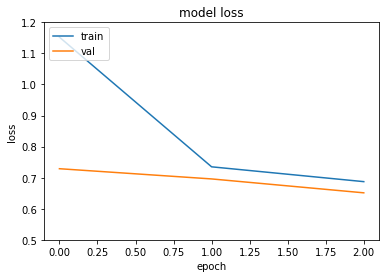

In [ ]:
plot_loss(history, 0.5, 1.2)

### Distilroberta-base models training

#### Distilroberta-base seed 42

##### Without history

In [ ]:
history = prepare_and_start_training(model, x_train, y_train, x_val, y_val, 
                                     seed_ind=0, use_history=False, save=True)

No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


Epoch 1/3


/usr/local/lib/python3.8/dist-packages/tensorflow/python/autograph/impl/api.py:371: FutureWarning: Version v4.17.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.17.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  return py_builtins.overload_of(f)(*args)


625/625 [==============================] - 904s 1s/step - loss: 1.2658 - val_loss: 0.9859
Epoch 2/3
625/625 [==============================] - 882s 1s/step - loss: 0.9134 - val_loss: 0.9226
Epoch 3/3
625/625 [==============================] - 883s 1s/step - loss: 0.8200 - val_loss: 0.8682


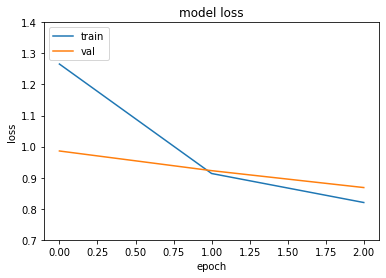

In [ ]:
plot_loss(history, 0.7, 1.4)

##### With history

In [ ]:
history = prepare_and_start_training(model, x_train, y_train, x_val, y_val, 
                                     seed_ind=0, use_history=True, save=True)

No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


Epoch 1/3


/usr/local/lib/python3.8/dist-packages/tensorflow/python/autograph/impl/api.py:371: FutureWarning: Version v4.17.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.17.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  return py_builtins.overload_of(f)(*args)


625/625 [==============================] - 901s 1s/step - loss: 1.2693 - val_loss: 0.9823
Epoch 2/3
625/625 [==============================] - 878s 1s/step - loss: 0.9116 - val_loss: 0.9297
Epoch 3/3
625/625 [==============================] - 913s 1s/step - loss: 0.8168 - val_loss: 0.8379


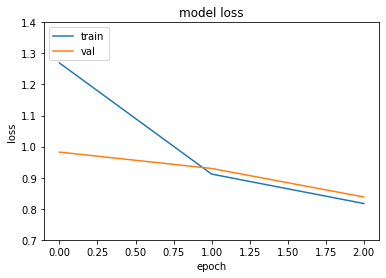

In [ ]:
plot_loss(history, 0.7, 1.4)

#### Distilroberta-base seed 2022

##### Without history

In [ ]:
history = prepare_and_start_training(model, x_train, y_train, x_val, y_val, 
                                     seed_ind=1, use_history=False, save=True)

No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


Epoch 1/3


/usr/local/lib/python3.8/dist-packages/tensorflow/python/autograph/impl/api.py:371: FutureWarning: Version v4.17.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.17.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  return py_builtins.overload_of(f)(*args)


625/625 [==============================] - 925s 1s/step - loss: 1.2399 - val_loss: 0.9817
Epoch 2/3
625/625 [==============================] - 858s 1s/step - loss: 0.9010 - val_loss: 0.9072
Epoch 3/3
625/625 [==============================] - 892s 1s/step - loss: 0.8062 - val_loss: 0.8476


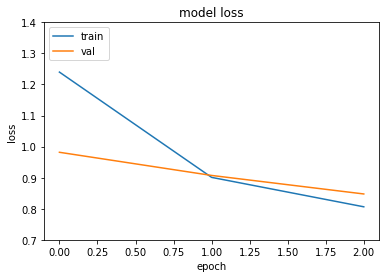

In [ ]:
plot_loss(history, 0.7, 1.4)

##### With history

In [ ]:
history = prepare_and_start_training(model, x_train, y_train, x_val, y_val, 
                                     seed_ind=1, use_history=True, save=True)

No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


Epoch 1/3


/usr/local/lib/python3.8/dist-packages/tensorflow/python/autograph/impl/api.py:371: FutureWarning: Version v4.17.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.17.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  return py_builtins.overload_of(f)(*args)


625/625 [==============================] - 952s 1s/step - loss: 1.2430 - val_loss: 0.9798
Epoch 2/3
625/625 [==============================] - 898s 1s/step - loss: 0.9018 - val_loss: 0.9241
Epoch 3/3
625/625 [==============================] - 929s 1s/step - loss: 0.8167 - val_loss: 0.8481


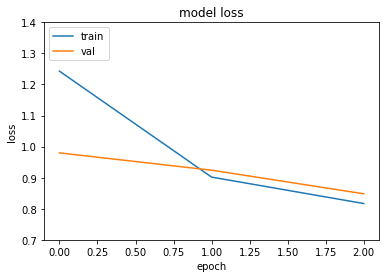

In [ ]:
plot_loss(history, 0.7, 1.4)

#### Distilroberta-base seed 1337

##### Without history

In [ ]:
history = prepare_and_start_training(model, x_train, y_train, x_val, y_val, 
                                     seed_ind=2, use_history=False, save=True)

No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


Epoch 1/3


/usr/local/lib/python3.8/dist-packages/tensorflow/python/autograph/impl/api.py:371: FutureWarning: Version v4.17.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.17.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  return py_builtins.overload_of(f)(*args)


625/625 [==============================] - 947s 1s/step - loss: 1.2394 - val_loss: 0.9752
Epoch 2/3
625/625 [==============================] - 919s 1s/step - loss: 0.9042 - val_loss: 0.9098
Epoch 3/3
625/625 [==============================] - 921s 1s/step - loss: 0.8138 - val_loss: 0.8610


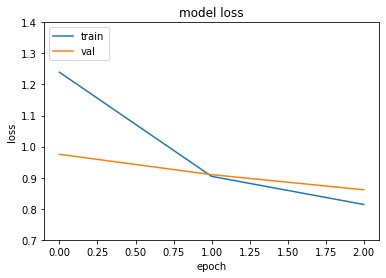

In [ ]:
plot_loss(history, 0.7, 1.4)

##### With history

In [ ]:
history = prepare_and_start_training(model, x_train, y_train, x_val, y_val, 
                                     seed_ind=2, use_history=True, save=True)

No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


Epoch 1/3


/usr/local/lib/python3.8/dist-packages/tensorflow/python/autograph/impl/api.py:371: FutureWarning: Version v4.17.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.17.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  return py_builtins.overload_of(f)(*args)


625/625 [==============================] - 921s 1s/step - loss: 1.2370 - val_loss: 0.9721
Epoch 2/3
625/625 [==============================] - 903s 1s/step - loss: 0.9041 - val_loss: 0.9259
Epoch 3/3
625/625 [==============================] - 905s 1s/step - loss: 0.8218 - val_loss: 0.8582


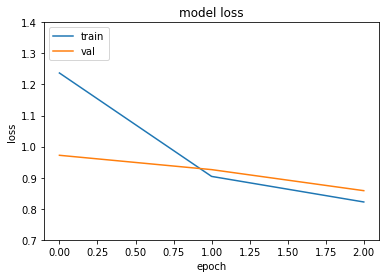

In [ ]:
plot_loss(history, 0.7, 1.4)

## Compute squad f1 score [TASK 6 b, TASK 7]

The f1 score was computed for each model using the predicted answers and the groundtruth.

To make the whole process more efficient, once we computed the predicted answers and the f1 score for each model, we decided to save a DataFrame with all questions, answers and predicted ones both for test and validation sets (limited to the same number of elements).

You can import the dataframe with the following cell in order to run the evaluation part of the notebook.

In [27]:
df_eval_path = os.path.join(drive_weights_path, 'df_final_evaluation.pkl')
df_final_evaluation = pd.read_pickle(df_eval_path)

In order to compute the squad f1 score we decided to use the [squad metric](https://huggingface.co/spaces/evaluate-metric/squad) from Huggingface. 

In [28]:
!pip install evaluate -q
import evaluate

     |████████████████████████████████| 72 kB 1.3 MB/s 


In [29]:
f1_metric = evaluate.load("squad")

The next function was used to compute the f1 score and the predicted answers for each model but after that we saved the results, we deleted all the relative code and we left this function for completeness. 

Moreover to avoid problem of RAM allocation with this function (model.generate gave OOM error if we tried to run on the full test set), we generated batch of results and then we merged them together before computing the f1 score.

In [30]:
#@title #### Function for computing the f1 score on the entire dataset 
#@markdown This function was used to compute the predicted answers and the f1
#@markdown score for each model before we saved the results.
def compute_f1_score(model: TFEncoderDecoderModel, X: dict, answers: List[str],
                     metric: evaluate.EvaluationModule, tokenizer,
                     num_samples: Optional[int]=None, max_length: int=20, batch_size: int=500, 
                     return_pred_answers: bool=False) -> Tuple[float, list]:
    '''
        This function takes as input a dataset, it runs inference on the given
        model and then it returns the F1 score metric.
        Parameters:
            - model: transformers.models
                The model to run inference on.
            - X: dict
                The structure that contains the input_ids and attention_mask, it
                is obtained doing 'variable.data' on an object of type
                transformers.tokenization_utils_base.BatchEncoding.
            - answers: list
                The array of strings of answers.
            - metric: evaluate.Metric
                It's the metric object to consider for the computation.
            - tokenizer:
                The tokenizer of the model.
            - num_samples: int 
                The function takes from the samples the first 'num_samples'
                samples.
            - max_length: int
                It's the maximum length used during the generation
            - batch_size: int
                It's the batch size used to pass this number of answers to the 
                model (to avoid RAM allocation error).
            - return_pred_answers: bool
                If the function has to return the array of predicted answers.

        Returns:
            - (float, list)
                The f1 score and the array of predicted answers if return_pred_answers
                is True, only the f1 score and an empty list otherwise.
    '''
    # Take all the samples
    if num_samples == None:
        num_samples = len(answers)
    
    assert num_samples > batch_size, "ERROR: the batch size is greater than the number of samples."
    
    ids, att_mask = X['input_ids'][:num_samples], X['attention_mask'][:num_samples]

    num_step = num_samples//batch_size
    # The last batch may be smaller than the batch_size 
    last_batch_size = num_samples - (num_step*batch_size)

    predicted_answers = []
    print("Computing the f1 score ... \n")
    for i in tqdm(range(num_step+1)):
        start = batch_size*(i)

        # Check if it has to run the last batch with a different size
        if i >= num_step:
            if last_batch_size > 0:
                batch_size = last_batch_size
            else:
                break

        out = model.generate(ids[start:start+batch_size], 
                             attention_mask=att_mask[start:start+batch_size],
                             max_length=max_length).numpy()

        refs = []
        preds = []
        for j in range(start, start+batch_size):
            # The model output is always of 'batch_size' elements so I need to
            # access the j - start element
            pred_string = tokenizer.decode(out[j-start], skip_special_tokens=True)
            if return_pred_answers:
                predicted_answers.append(pred_string)

            preds.append({'prediction_text':pred_string, 'id':str(j)})
            refs.append({'answers': {'text':[answers[j]],'answer_start':[0],},'id':str(j)})

        metric.add_batch(predictions=preds, references=refs)

    f1_score = metric.compute()
    assert f1_score is not None
    
    return f1_score['f1'], predicted_answers

For simplicity we decided to divide the imported evaluation dataframe in 2 dataframes, one for the validation set and the other for the test set such that we can better select the desired model during the evaluation.

In [31]:
#@title #### Function for splitting the evaluation dataframe 
def split_eval_df(df):
    val_cols = []
    test_cols = ['source']
    # Find all the columns that are of validation or test set
    for col in df.columns:
        if col.startswith('test') or col.endswith('test'):
            test_cols.append(col)
        else:
            val_cols.append(col)

    df_test_eval, df_val_eval = df[test_cols], df[val_cols]
    return df_test_eval, df_val_eval

In [32]:
df_test_eval, df_val_eval = split_eval_df(df_final_evaluation)

df_test_eval = df_test_eval.rename({'test_story':'story', 'test_quest':'questions',
                                    'test_answ': 'answers'}, axis=1)
df_val_eval = df_val_eval.rename({'val_story':'story', 'val_quest':'questions',
                                  'val_answ': 'answers'}, axis=1);

As explained before, the following functions work on the imported dataframe (actually the 2 splitted ones) due to efficiency and convenience and they are used from now on.

In [33]:
#@title #### New function to compute f1 score using dataframe imported from pickle

def get_selected_model(df, model_name, with_history, seed):
    '''
        Given the evaluation dataframe and the different parameters it returns
        the dataframe with the source, story, questions, answers and the predicted
        answers of the desired model.
    '''
    mod_abbr = 'rob' if 'roberta' in model_name else 'bert'
    hist = '_h' if with_history else 'nh'

    correct_cols = lambda x: mod_abbr in x and hist in x and str(seed) in x
    
    # Take the source, story, questions, answers and the other correct ones 
    sel_model = [col for col in df.columns[4:] if correct_cols(col)]
    cols = list(df.columns[:4]) + sel_model

    assert len(cols) > 4, "ERROR: with the selected combination there is no model."
    
    res = df[cols].rename({sel_model[0]: 'predictions'}, axis=1)
    print(f"The model {model_name} {'with' if with_history else 'without'} the history"
          f" and seed {seed} has been selected.\n")
    
    return res



def add_sample_metric(sample, metric):
    pred = {'prediction_text':sample['predictions'], 'id':str(sample.name)}
    ref = {'answers': {'text':[sample['answers']],'answer_start':[0],},'id':str(sample.name)}

    metric.add(prediction=pred, reference=ref)
    return sample

def compute_f1_score_eval(df: pd.DataFrame, model_name: str, with_history: bool,
                          seed: int, metric) -> float:

    clean = get_selected_model(df, model_name, with_history, seed)
    # Add elements to the f1 metric
    clean.apply(add_sample_metric, metric=metric, axis=1)

    f1_score = metric.compute()
    assert f1_score is not None

    return f1_score['f1']

In [34]:
#@title #### Functions to compute f1 score by source and dialogue [TASK 7]
def compute_f1_group(sample, metric):
    '''
        It computes the f1 score and the sum of the questions, answers and predicted
        answers for the samples within a same dialogue provided by a source.
    '''
    sumstr = []
    for i, (ans, pr) in enumerate(zip(sample['answers'], sample['predictions'])):
        pred = {'prediction_text':pr, 'id':str(i)}
        ref = {'answers': {'text':[ans],'answer_start':[0]},'id':str(i)}
        metric.add(prediction=pred, reference=ref)
        sumstr.append(f"Q:{sample['questions'].iloc[i]} A:{ans} P:{pr}")

    return pd.Series({'f1':metric.compute()['f1'], 'dialogue': sumstr})


def f1_score_source_dialogue(df_eval, model_name, with_history, seed, metric, 
                             drop_index=None):
    '''
        Returns a DataFrame with 2 additional columns, one for the f1 score at
        a dialogue level and another for the dialogue with the questions, the 
        answers and the predicted answers.
    '''

    df_sel = get_selected_model(df_eval, model_name, with_history, seed)
    new_df = df_sel.groupby(['source','story'], sort=True) \
                    .apply(compute_f1_group, metric=metric)

    if drop_index is not None:
        assert isinstance(drop_index, bool), "ERROR: drop_index needs to be a bool."
        new_df = new_df.reset_index(drop=drop_index)
    return new_df


def k_worst_best_dialogues(df_f1: pd.DataFrame, mode: str='worst', k: int=5):
    '''
        It returns the k best / worst dialogues for each source.
        Parameters:
            - df_f1: pd.DataFrame
                The dataframe on which we want to perform the operation, must be
                the dataframe for which the f1 has already been calculated for
                each dialogue.
            - mode: str
                - 'worst': returns the k worst dialogues considering the f1 score.
                - 'best': returns the k best dialogues considering the f1 score.
                - 'both': returns 2 dataframes, one for the k best dialogues and
                   one for the k worst dialogues for each source.
            - k: int
                The number of dialogues to return for each source.
        
        Returns:
            - Tuple(pd.DataFrame, pd.DataFrame) | Tuple(pd.DataFrame, None)
                If the function needs to return only one DataFrame, the second
                element of the tuple is None, otherwise it returns the 'best' one 
                first and then the other.
    '''
    best_df, worst_df = None, None
    if mode == 'worst':
        worst_df = df_f1.groupby('source', as_index=False) \
                    .apply(lambda x: x.nsmallest(k, columns=['f1']))
        return worst_df, best_df

    elif mode == 'best':
        best_df = df_f1.groupby('source', as_index=False) \
                    .apply(lambda x: x.nlargest(k, columns=['f1']))
        return best_df, worst_df

    elif mode == 'both':
        best_df = df_f1.groupby('source', as_index=False) \
                    .apply(lambda x: x.nlargest(k, columns=['f1']))
        worst_df = df_f1.groupby('source', as_index=False) \
                    .apply(lambda x: x.nsmallest(k, columns=['f1']))
        return best_df, worst_df

### Bert-tiny models f1 evaluation

#### Bert-tiny seed 42

##### Without history

In [ ]:
f1_nohist_42_test = compute_f1_score_eval(df_test_eval, bertiny_name, False, seeds[0], f1_metric)
print(f"The f1 score on the test set is {round(f1_nohist_42_test, 2)}")

The model prajjwal1/bert-tiny without the history and seed 42 has been selected.

The f1 score on the test set is 12.47


In [ ]:
f1_nohist_42_val = compute_f1_score_eval(df_val_eval, bertiny_name, False, seeds[0], f1_metric)
print(f"The f1 score on the validation set is {round(f1_nohist_42_val, 2)}")

The model prajjwal1/bert-tiny without the history and seed 42 has been selected.

The f1 score on the validation set is 11.76


In [ ]:
df_f1_nohist_42 = f1_score_source_dialogue(df_test_eval, bertiny_name, False,
                                           seeds[0], f1_metric)

df_worst_nohist_42, _ = k_worst_best_dialogues(df_f1_nohist_42, mode='worst', k=5)
display(df_worst_nohist_42)

The model prajjwal1/bert-tiny without the history and seed 42 has been selected.



f1  \
  source    story                                                     
0 cnn       (CNN) -- A 16-year-old Pennsylvania boy is faci...  0.0   
            (CNN) -- A Russian bookmaking company is offeri...  0.0   
            (CNN) -- According to the "Guinness Book of Wor...  0.0   
            (CNN) -- Brad Pitt clearly has a great deal goi...  0.0   
            (CNN) -- FBI agents on Friday night searched th...  0.0   
1 gutenberg CHAPTER FIFTY FIVE. \n\nWAITING. \n\nThe length...  0.0   
            CHAPTER IV. \n\nLady Wallinger and Edith were t...  0.0   
            CHAPTER VIII. \n\nHOSTAGE. \n\nThe revolution o...  0.0   
            CHAPTER VIII. STEAD IN POSSESSION. \n\n"At nigh...  0.0   
            CHAPTER X \n\nAfter nearly a year's captivity, ...  0.0   
2 mctest    A boy named Pedro was walking down the street o...  0.0   
            Andrew waited for his granddaddy to show up. Th...  0.0   
            Annie was helping her little brother Max pick f...  0.0   
            As Michael put each finger on the white laces o...  0.0   
            David and Sue went to their Auntie's house to v...  0.0   
3 race      "What is success"? Mr. Black asked his 6th grad...  0.0   
            A couple of weeks ago, my 12-year-old daughter,...  0.0   
            A great loss--Shirley Temple dies at 85 \n\nFeb...  0.0   
            Canada geese are large blue and white birds .Wh...  0.0   
            Christopher Thomas, 27, was a writer by night a...  0.0   
4 wikipedia A psychological identity relates to self-image ...  0.0   
            A social class (or, simply, class), as in class...  0.0   
            A thorough understanding of adolescence in soci...  0.0   
            A440 or A4 (also known as the Stuttgart pitch),...  0.0   
            Cork was originally a monastic settlement, repu...  0.0   

                                                                                                         dialogue  
  source    story                                                                                                  
0 cnn       (CNN) -- A 16-year-old Pennsylvania boy is faci...  [Q:HOW OLD IS THE PERSPECTIVE? A:16 P:two, Q:W...  
            (CNN) -- A Russian bookmaking company is offeri...  [Q:What did the firm do with the offer? A:decl...  
            (CNN) -- According to the "Guinness Book of Wor...  [Q:What is the most popular character in films...  
            (CNN) -- Brad Pitt clearly has a great deal goi...  [Q:How many children does he have? A:Six. P:tw...  
            (CNN) -- FBI agents on Friday night searched th...  [Q:Whose house was searched? A:Gary Giordano P...  
1 gutenberg CHAPTER FIFTY FIVE. \n\nWAITING. \n\nThe length...  [Q:Who was excommunicated? A:Fra Girolamo P:th...  
            CHAPTER IV. \n\nLady Wallinger and Edith were t...  [Q:Was someone in the morning room alone? A:no...  
            CHAPTER VIII. \n\nHOSTAGE. \n\nThe revolution o...  [Q:What was the revolution A:Todos Santos P:th...  
            CHAPTER VIII. STEAD IN POSSESSION. \n\n"At nigh...  [Q:Who surrendered? A:the garrison of Bristol ...  
            CHAPTER X \n\nAfter nearly a year's captivity, ...  [Q:What was the King to pay? A:a ransom P:the ...  
2 mctest    A boy named Pedro was walking down the street o...  [Q:How many times do you have to ring the bell...  
            Andrew waited for his granddaddy to show up. Th...  [Q:Why? A:Because they were going fishing. P:h...  
            Annie was helping her little brother Max pick f...  [Q:What holiday was coming up? A:Mother's Day ...  
            As Michael put each finger on the white laces o...  [Q:What sport was Michael playing? A:football ...  
            David and Sue went to their Auntie's house to v...  [Q:When did they go to visit their Aunt? A:Sat...  
3 race      "What is success"? Mr. Black asked his 6th grad...  [Q:mr black asked what ? A:What is success P:h...  
            A couple of weeks ago, my 12-year-old daughter,

You can explore furtherly the dialogues choosing one from the dataframe and you will see in the case of the worst ones that the model is wrong to answer all the questions.

In [ ]:
df_worst_nohist_42.reset_index(drop=True)['dialogue'][0]

['Q:HOW OLD IS THE PERSPECTIVE? A:16 P:two',
 'Q:WHERE IS HE FROM? A:Pennsylvania P:the united states',
 'Q:WHAT CHARGES IS HE FACING. A:multiple counts of murder in the first, second and third degrees, as well as robbery and firearms-related offenses P:the world',
 'Q:WHAT IS THE 16 YEAR OLDS NAME? A:Aazis Richardson P:the united states',
 'Q:WHO DID HE SHOOT? A:Vincent Darbenzio P:the president',
 'Q:WHAT DID HE DO FOR A LIVING A:cab driver P:a new york',
 'Q:HOW OLD WAS HE? A:47 P:two',
 "Q:WHERE DID HE SHOOT HIM>' A:back of his head P:in the united states",
 'Q:AND THE LOCATION? A:in the cab P:the united states',
 'Q:FOR WHAT REASON? A:He ignored his route suggestions. P:a - - term',
 'Q:WHAT DID HE BELIEVE WAS THE INTENTION? A:To attempt to increase the fare. P:a new york',
 'Q:WHAT COUNTY IS HOLDING THE CASE? A:Lackawanna County P:the united states',
 'Q:DOES THE BOY SHOW REMORSE? A:No P:yes',
 'Q:WHAT MAKES YOU SAY THAT? A:He said "my homies died, everybody gotta die." P:a lot o

##### With history

In [ ]:
f1_hist_42_test = compute_f1_score_eval(df_test_eval, bertiny_name, True, seeds[0], f1_metric)
print(f"The f1 score on the test set is {round(f1_hist_42_test, 2)}")

The model prajjwal1/bert-tiny with the history and seed 42 has been selected.

The f1 score on the test set is 12.38


In [ ]:
f1_hist_42_val = compute_f1_score_eval(df_val_eval, bertiny_name, True, seeds[0], f1_metric)
print(f"The f1 score on the validation set is {round(f1_hist_42_val, 2)}")

The model prajjwal1/bert-tiny with the history and seed 42 has been selected.

The f1 score on the validation set is 11.56


In [ ]:
df_f1_hist_42 = f1_score_source_dialogue(df_test_eval, bertiny_name, True,
                                           seeds[0], f1_metric)

df_worst_hist_42, _ = k_worst_best_dialogues(df_f1_hist_42, mode='worst', k=5)
display(df_worst_hist_42)

The model prajjwal1/bert-tiny with the history and seed 42 has been selected.



f1  \
  source    story                                                     
0 cnn       (CNN) -- A 16-year-old Pennsylvania boy is faci...  0.0   
            (CNN) -- According to the "Guinness Book of Wor...  0.0   
            (CNN) -- Brad Pitt clearly has a great deal goi...  0.0   
            (CNN) -- His was a suicide with a macabre twist...  0.0   
            (CNN) -- Kenyan actress Lupita Nyong'o has beco...  0.0   
1 gutenberg CHAPTER 6 \n\nCan piety the discord heal, Or st...  0.0   
            CHAPTER FIFTY FIVE. \n\nWAITING. \n\nThe length...  0.0   
            CHAPTER IV. \n\nLady Wallinger and Edith were t...  0.0   
            CHAPTER VIII. \n\nHOSTAGE. \n\nThe revolution o...  0.0   
            CHAPTER VIII. STEAD IN POSSESSION. \n\n"At nigh...  0.0   
2 mctest    A boy named Pedro was walking down the street o...  0.0   
            Andrew waited for his granddaddy to show up. Th...  0.0   
            Annie was helping her little brother Max pick f...  0.0   
            As Michael put each finger on the white laces o...  0.0   
            Hey! That isn't fair! Knights can't fly! Only w...  0.0   
3 race      "What is success"? Mr. Black asked his 6th grad...  0.0   
            A couple of weeks ago, my 12-year-old daughter,...  0.0   
            A great loss--Shirley Temple dies at 85 \n\nFeb...  0.0   
            Canada geese are large blue and white birds .Wh...  0.0   
            Christopher Thomas, 27, was a writer by night a...  0.0   
4 wikipedia A psychological identity relates to self-image ...  0.0   
            A social class (or, simply, class), as in class...  0.0   
            A thorough understanding of adolescence in soci...  0.0   
            A440 or A4 (also known as the Stuttgart pitch),...  0.0   
            Cork was originally a monastic settlement, repu...  0.0   

                                                                                                         dialogue  
  source    story                                                                                                  
0 cnn       (CNN) -- A 16-year-old Pennsylvania boy is faci...  [Q:HOW OLD IS THE PERSPECTIVE? A:16 P:two, Q:W...  
            (CNN) -- According to the "Guinness Book of Wor...  [Q:What is the most popular character in films...  
            (CNN) -- Brad Pitt clearly has a great deal goi...  [Q:How many children does he have? A:Six. P:tw...  
            (CNN) -- His was a suicide with a macabre twist...  [Q:What did David want done with his brain? A:...  
            (CNN) -- Kenyan actress Lupita Nyong'o has beco...  [Q:Who was born in Mexico but not raised there...  
1 gutenberg CHAPTER 6 \n\nCan piety the discord heal, Or st...  [Q:Who wanted a friend like her brother? A:Mrs...  
            CHAPTER FIFTY FIVE. \n\nWAITING. \n\nThe length...  [Q:Who was excommunicated? A:Fra Girolamo P:th...  
            CHAPTER IV. \n\nLady Wallinger and Edith were t...  [Q:Was someone in the morning room alone? A:no...  
            CHAPTER VIII. \n\nHOSTAGE. \n\nThe revolution o...  [Q:What was the revolution A:Todos Santos P:th...  
            CHAPTER VIII. STEAD IN POSSESSION. \n\n"At nigh...  [Q:Who surrendered? A:the garrison of Bristol ...  
2 mctest    A boy named Pedro was walking down the street o...  [Q:How many times do you have to ring the bell...  
            Andrew waited for his granddaddy to show up. Th...  [Q:Why? A:Because they were going fishing. P:h...  
            Annie was helping her little brother Max pick f...  [Q:What holiday was coming up? A:Mother's Day ...  
            As Michael put each finger on the white laces o...  [Q:What sport was Michael playing? A:football ...  
            Hey! That isn't fair! Knights can't fly! Only w...  [Q:What character is Frank playing? A:Knight P...  
3 race      "What is success"? Mr. Black asked his 6th grad...  [Q:mr black asked what ? A:What is success P:h...  
            A couple of weeks ago, my 12-year-old daughter,

You can explore furtherly the dialogues choosing one from the dataframe and you will see in the case of the worst ones that the model is wrong to answer all the questions.

In [ ]:
df_worst_hist_42.reset_index(drop=True)['dialogue'][0]

['Q:HOW OLD IS THE PERSPECTIVE? A:16 P:two',
 'Q:WHERE IS HE FROM? A:Pennsylvania P:the united states',
 'Q:WHAT CHARGES IS HE FACING. A:multiple counts of murder in the first, second and third degrees, as well as robbery and firearms-related offenses P:the world',
 'Q:WHAT IS THE 16 YEAR OLDS NAME? A:Aazis Richardson P:the united states',
 'Q:WHO DID HE SHOOT? A:Vincent Darbenzio P:the president',
 'Q:WHAT DID HE DO FOR A LIVING A:cab driver P:the world',
 'Q:HOW OLD WAS HE? A:47 P:two',
 "Q:WHERE DID HE SHOOT HIM>' A:back of his head P:the united states",
 'Q:AND THE LOCATION? A:in the cab P:the united states',
 'Q:FOR WHAT REASON? A:He ignored his route suggestions. P:a new york',
 'Q:WHAT DID HE BELIEVE WAS THE INTENTION? A:To attempt to increase the fare. P:the world',
 'Q:WHAT COUNTY IS HOLDING THE CASE? A:Lackawanna County P:the united states',
 'Q:DOES THE BOY SHOW REMORSE? A:No P:yes',
 'Q:WHAT MAKES YOU SAY THAT? A:He said "my homies died, everybody gotta die." P:a lot of the

#### Bert-tiny seed 2022

##### Without history

In [ ]:
f1_nohist_2022_test = compute_f1_score_eval(df_test_eval, bertiny_name, False, seeds[1], f1_metric)
print(f"The f1 score on the test set is {round(f1_nohist_2022_test, 2)}")

The model prajjwal1/bert-tiny without the history and seed 2022 has been selected.

The f1 score on the test set is 12.52


In [ ]:
f1_nohist_2022_val = compute_f1_score_eval(df_val_eval, bertiny_name, False, seeds[1], f1_metric)
print(f"The f1 score on the validation set is {round(f1_nohist_2022_val, 2)}")

The model prajjwal1/bert-tiny without the history and seed 2022 has been selected.

The f1 score on the validation set is 11.69


In [ ]:
df_f1_nohist_2022 = f1_score_source_dialogue(df_test_eval, bertiny_name, False,
                                           seeds[1], f1_metric)

df_worst_nohist_2022, _ = k_worst_best_dialogues(df_f1_nohist_2022, mode='worst', k=5)
display(df_worst_nohist_2022)

The model prajjwal1/bert-tiny without the history and seed 2022 has been selected.



f1  \
  source    story                                                     
0 cnn       (CNN) -- A 16-year-old Pennsylvania boy is faci...  0.0   
            (CNN) -- A Russian bookmaking company is offeri...  0.0   
            (CNN) -- According to the "Guinness Book of Wor...  0.0   
            (CNN) -- Brad Pitt clearly has a great deal goi...  0.0   
            (CNN) -- FBI agents on Friday night searched th...  0.0   
1 gutenberg CHAPTER 6 \n\nCan piety the discord heal, Or st...  0.0   
            CHAPTER FIFTY FIVE. \n\nWAITING. \n\nThe length...  0.0   
            CHAPTER IV. \n\nLady Wallinger and Edith were t...  0.0   
            CHAPTER IX--GONE OVER TO THE ENEMY \n\n\n\n"Can...  0.0   
            CHAPTER VIII. \n\nHOSTAGE. \n\nThe revolution o...  0.0   
2 mctest    A boy named Pedro was walking down the street o...  0.0   
            Andrew waited for his granddaddy to show up. Th...  0.0   
            Annie was helping her little brother Max pick f...  0.0   
            As Michael put each finger on the white laces o...  0.0   
            David and Sue went to their Auntie's house to v...  0.0   
3 race      "If I rest, I _ "----would be an excellent mott...  0.0   
            "What is success"? Mr. Black asked his 6th grad...  0.0   
            A couple of weeks ago, my 12-year-old daughter,...  0.0   
            A great loss--Shirley Temple dies at 85 \n\nFeb...  0.0   
            Canada geese are large blue and white birds .Wh...  0.0   
4 wikipedia A psychological identity relates to self-image ...  0.0   
            A social class (or, simply, class), as in class...  0.0   
            A thorough understanding of adolescence in soci...  0.0   
            A440 or A4 (also known as the Stuttgart pitch),...  0.0   
            Cork was originally a monastic settlement, repu...  0.0   

                                                                                                         dialogue  
  source    story                                                                                                  
0 cnn       (CNN) -- A 16-year-old Pennsylvania boy is faci...  [Q:HOW OLD IS THE PERSPECTIVE? A:16 P:two, Q:W...  
            (CNN) -- A Russian bookmaking company is offeri...  [Q:What did the firm do with the offer? A:decl...  
            (CNN) -- According to the "Guinness Book of Wor...  [Q:What is the most popular character in films...  
            (CNN) -- Brad Pitt clearly has a great deal goi...  [Q:How many children does he have? A:Six. P:tw...  
            (CNN) -- FBI agents on Friday night searched th...  [Q:Whose house was searched? A:Gary Giordano P...  
1 gutenberg CHAPTER 6 \n\nCan piety the discord heal, Or st...  [Q:Who wanted a friend like her brother? A:Mrs...  
            CHAPTER FIFTY FIVE. \n\nWAITING. \n\nThe length...  [Q:Who was excommunicated? A:Fra Girolamo P:th...  
            CHAPTER IV. \n\nLady Wallinger and Edith were t...  [Q:Was someone in the morning room alone? A:no...  
            CHAPTER IX--GONE OVER TO THE ENEMY \n\n\n\n"Can...  [Q:Who's the top quote by? A:E. B. BROWNING. P...  
            CHAPTER VIII. \n\nHOSTAGE. \n\nThe revolution o...  [Q:What was the revolution A:Todos Santos P:th...  
2 mctest    A boy named Pedro was walking down the street o...  [Q:How many times do you have to ring the bell...  
            Andrew waited for his granddaddy to show up. Th...  [Q:Why? A:Because they were going fishing. P:h...  
            Annie was helping her little brother Max pick f...  [Q:What holiday was coming up? A:Mother's Day ...  
            As Michael put each finger on the white laces o...  [Q:What sport was Michael playing? A:football ...  
            David and Sue went to their Auntie's house to v...  [Q:When did they go to visit their Aunt? A:Sat...  
3 race      "If I rest, I _ "----would be an excellent mott...  [Q:What defeats all? A:Labor P:the world, Q:Wh...  
            "What is success"? Mr. Black asked his 6th grad

You can explore furtherly the dialogues choosing one from the dataframe and you will see in the case of the worst ones that the model is wrong to answer all the questions.

In [ ]:
df_worst_nohist_2022.reset_index(drop=True)['dialogue'][0]

['Q:HOW OLD IS THE PERSPECTIVE? A:16 P:two',
 'Q:WHERE IS HE FROM? A:Pennsylvania P:the united states',
 'Q:WHAT CHARGES IS HE FACING. A:multiple counts of murder in the first, second and third degrees, as well as robbery and firearms-related offenses P:the world war',
 'Q:WHAT IS THE 16 YEAR OLDS NAME? A:Aazis Richardson P:the united states',
 'Q:WHO DID HE SHOOT? A:Vincent Darbenzio P:the president',
 'Q:WHAT DID HE DO FOR A LIVING A:cab driver P:a man',
 'Q:HOW OLD WAS HE? A:47 P:two',
 "Q:WHERE DID HE SHOOT HIM>' A:back of his head P:the united states",
 'Q:AND THE LOCATION? A:in the cab P:the united states',
 'Q:FOR WHAT REASON? A:He ignored his route suggestions. P:a - - term',
 'Q:WHAT DID HE BELIEVE WAS THE INTENTION? A:To attempt to increase the fare. P:a man',
 'Q:WHAT COUNTY IS HOLDING THE CASE? A:Lackawanna County P:the united states',
 'Q:DOES THE BOY SHOW REMORSE? A:No P:yes',
 'Q:WHAT MAKES YOU SAY THAT? A:He said "my homies died, everybody gotta die." P:a man',
 'Q:WHO 

##### With history

In [ ]:
f1_hist_2022_test = compute_f1_score_eval(df_test_eval, bertiny_name, True, seeds[1], f1_metric)
print(f"The f1 score on the test set is {round(f1_hist_2022_test, 2)}")

The model prajjwal1/bert-tiny with the history and seed 2022 has been selected.

The f1 score on the test set is 12.37


In [ ]:
f1_hist_2022_val = compute_f1_score_eval(df_val_eval, bertiny_name, True, seeds[1], f1_metric)
print(f"The f1 score on the validation set is {round(f1_hist_2022_val, 2)}")

The model prajjwal1/bert-tiny with the history and seed 2022 has been selected.

The f1 score on the validation set is 11.48


In [ ]:
df_f1_hist_2022 = f1_score_source_dialogue(df_test_eval, bertiny_name, True,
                                           seeds[1], f1_metric)

df_worst_hist_2022, _ = k_worst_best_dialogues(df_f1_hist_2022, mode='worst', k=5)
display(df_worst_hist_2022)

The model prajjwal1/bert-tiny with the history and seed 2022 has been selected.



f1  \
  source    story                                                     
0 cnn       (CNN) -- A 16-year-old Pennsylvania boy is faci...  0.0   
            (CNN) -- A Russian bookmaking company is offeri...  0.0   
            (CNN) -- According to the "Guinness Book of Wor...  0.0   
            (CNN) -- Brad Pitt clearly has a great deal goi...  0.0   
            (CNN) -- FBI agents on Friday night searched th...  0.0   
1 gutenberg CHAPTER 6 \n\nCan piety the discord heal, Or st...  0.0   
            CHAPTER FIFTY FIVE. \n\nWAITING. \n\nThe length...  0.0   
            CHAPTER IV. \n\nLady Wallinger and Edith were t...  0.0   
            CHAPTER IX--GONE OVER TO THE ENEMY \n\n\n\n"Can...  0.0   
            CHAPTER VIII. \n\nHOSTAGE. \n\nThe revolution o...  0.0   
2 mctest    A boy named Pedro was walking down the street o...  0.0   
            Andrew waited for his granddaddy to show up. Th...  0.0   
            Annie was helping her little brother Max pick f...  0.0   
            As Michael put each finger on the white laces o...  0.0   
            Hey! That isn't fair! Knights can't fly! Only w...  0.0   
3 race      "What is success"? Mr. Black asked his 6th grad...  0.0   
            A couple of weeks ago, my 12-year-old daughter,...  0.0   
            A great loss--Shirley Temple dies at 85 \n\nFeb...  0.0   
            Canada geese are large blue and white birds .Wh...  0.0   
            Christopher Thomas, 27, was a writer by night a...  0.0   
4 wikipedia A psychological identity relates to self-image ...  0.0   
            A social class (or, simply, class), as in class...  0.0   
            A thorough understanding of adolescence in soci...  0.0   
            A440 or A4 (also known as the Stuttgart pitch),...  0.0   
            Cork was originally a monastic settlement, repu...  0.0   

                                                                                                         dialogue  
  source    story                                                                                                  
0 cnn       (CNN) -- A 16-year-old Pennsylvania boy is faci...  [Q:HOW OLD IS THE PERSPECTIVE? A:16 P:two, Q:W...  
            (CNN) -- A Russian bookmaking company is offeri...  [Q:What did the firm do with the offer? A:decl...  
            (CNN) -- According to the "Guinness Book of Wor...  [Q:What is the most popular character in films...  
            (CNN) -- Brad Pitt clearly has a great deal goi...  [Q:How many children does he have? A:Six. P:tw...  
            (CNN) -- FBI agents on Friday night searched th...  [Q:Whose house was searched? A:Gary Giordano P...  
1 gutenberg CHAPTER 6 \n\nCan piety the discord heal, Or st...  [Q:Who wanted a friend like her brother? A:Mrs...  
            CHAPTER FIFTY FIVE. \n\nWAITING. \n\nThe length...  [Q:Who was excommunicated? A:Fra Girolamo P:th...  
            CHAPTER IV. \n\nLady Wallinger and Edith were t...  [Q:Was someone in the morning room alone? A:no...  
            CHAPTER IX--GONE OVER TO THE ENEMY \n\n\n\n"Can...  [Q:Who's the top quote by? A:E. B. BROWNING. P...  
            CHAPTER VIII. \n\nHOSTAGE. \n\nThe revolution o...  [Q:What was the revolution A:Todos Santos P:th...  
2 mctest    A boy named Pedro was walking down the street o...  [Q:How many times do you have to ring the bell...  
            Andrew waited for his granddaddy to show up. Th...  [Q:Why? A:Because they were going fishing. P:h...  
            Annie was helping her little brother Max pick f...  [Q:What holiday was coming up? A:Mother's Day ...  
            As Michael put each finger on the white laces o...  [Q:What sport was Michael playing? A:football ...  
            Hey! That isn't fair! Knights can't fly! Only w...  [Q:What character is Frank playing? A:Knight P...  
3 race      "What is success"? Mr. Black asked his 6th grad...  [Q:mr black asked what ? A:What is success P:y...  
            A couple of weeks ago, my 12-year-old daughter,

You can explore furtherly the dialogues choosing one from the dataframe and you will see in the case of the worst ones that the model is wrong to answer all the questions.

In [ ]:
df_worst_hist_2022.reset_index(drop=True)['dialogue'][0]

['Q:HOW OLD IS THE PERSPECTIVE? A:16 P:two',
 'Q:WHERE IS HE FROM? A:Pennsylvania P:the united states',
 'Q:WHAT CHARGES IS HE FACING. A:multiple counts of murder in the first, second and third degrees, as well as robbery and firearms-related offenses P:the world war',
 'Q:WHAT IS THE 16 YEAR OLDS NAME? A:Aazis Richardson P:the united states',
 'Q:WHO DID HE SHOOT? A:Vincent Darbenzio P:the president',
 'Q:WHAT DID HE DO FOR A LIVING A:cab driver P:a new york',
 'Q:HOW OLD WAS HE? A:47 P:two',
 "Q:WHERE DID HE SHOOT HIM>' A:back of his head P:the united states",
 'Q:AND THE LOCATION? A:in the cab P:the united states',
 'Q:FOR WHAT REASON? A:He ignored his route suggestions. P:a - - term',
 'Q:WHAT DID HE BELIEVE WAS THE INTENTION? A:To attempt to increase the fare. P:a new york',
 'Q:WHAT COUNTY IS HOLDING THE CASE? A:Lackawanna County P:the united states',
 'Q:DOES THE BOY SHOW REMORSE? A:No P:yes',
 'Q:WHAT MAKES YOU SAY THAT? A:He said "my homies died, everybody gotta die." P:a man'

#### Bert-tiny seed 1337

##### Without history

In [ ]:
f1_nohist_1337_test = compute_f1_score_eval(df_test_eval, bertiny_name, False, seeds[2], f1_metric)
print(f"The f1 score on the test set is {round(f1_nohist_1337_test, 2)}")

The model prajjwal1/bert-tiny without the history and seed 1337 has been selected.

The f1 score on the test set is 12.27


In [ ]:
f1_nohist_1337_val = compute_f1_score_eval(df_val_eval, bertiny_name, False, seeds[2], f1_metric)
print(f"The f1 score on the validation set is {round(f1_nohist_1337_val, 2)}")

The model prajjwal1/bert-tiny without the history and seed 1337 has been selected.

The f1 score on the validation set is 11.48


In [ ]:
df_f1_nohist_1337 = f1_score_source_dialogue(df_test_eval, bertiny_name, False,
                                           seeds[2], f1_metric)

df_worst_nohist_1337, _ = k_worst_best_dialogues(df_f1_nohist_1337, mode='worst', k=5)
display(df_worst_nohist_1337)

The model prajjwal1/bert-tiny without the history and seed 1337 has been selected.



f1  \
  source    story                                                     
0 cnn       (CNN) -- A 16-year-old Pennsylvania boy is faci...  0.0   
            (CNN) -- Brad Pitt clearly has a great deal goi...  0.0   
            (CNN) -- FBI agents on Friday night searched th...  0.0   
            (CNN) -- His was a suicide with a macabre twist...  0.0   
            (CNN) -- Kenyan actress Lupita Nyong'o has beco...  0.0   
1 gutenberg CHAPTER 6 \n\nCan piety the discord heal, Or st...  0.0   
            CHAPTER FIFTY FIVE. \n\nWAITING. \n\nThe length...  0.0   
            CHAPTER IV. \n\nLady Wallinger and Edith were t...  0.0   
            CHAPTER IX \n\nTen days later, Harper and Joe L...  0.0   
            CHAPTER IX--GONE OVER TO THE ENEMY \n\n\n\n"Can...  0.0   
2 mctest    A boy named Pedro was walking down the street o...  0.0   
            Andrew waited for his granddaddy to show up. Th...  0.0   
            Annie was helping her little brother Max pick f...  0.0   
            As Michael put each finger on the white laces o...  0.0   
            David and Sue went to their Auntie's house to v...  0.0   
3 race      "If I rest, I _ "----would be an excellent mott...  0.0   
            "What is success"? Mr. Black asked his 6th grad...  0.0   
            A couple of weeks ago, my 12-year-old daughter,...  0.0   
            A great loss--Shirley Temple dies at 85 \n\nFeb...  0.0   
            Canada geese are large blue and white birds .Wh...  0.0   
4 wikipedia A psychological identity relates to self-image ...  0.0   
            A social class (or, simply, class), as in class...  0.0   
            A thorough understanding of adolescence in soci...  0.0   
            Cork was originally a monastic settlement, repu...  0.0   
            Gujarati is an Indo-Aryan language native to th...  0.0   

                                                                                                         dialogue  
  source    story                                                                                                  
0 cnn       (CNN) -- A 16-year-old Pennsylvania boy is faci...  [Q:HOW OLD IS THE PERSPECTIVE? A:16 P:two, Q:W...  
            (CNN) -- Brad Pitt clearly has a great deal goi...  [Q:How many children does he have? A:Six. P:tw...  
            (CNN) -- FBI agents on Friday night searched th...  [Q:Whose house was searched? A:Gary Giordano P...  
            (CNN) -- His was a suicide with a macabre twist...  [Q:What did David want done with his brain? A:...  
            (CNN) -- Kenyan actress Lupita Nyong'o has beco...  [Q:Who was born in Mexico but not raised there...  
1 gutenberg CHAPTER 6 \n\nCan piety the discord heal, Or st...  [Q:Who wanted a friend like her brother? A:Mrs...  
            CHAPTER FIFTY FIVE. \n\nWAITING. \n\nThe length...  [Q:Who was excommunicated? A:Fra Girolamo P:th...  
            CHAPTER IV. \n\nLady Wallinger and Edith were t...  [Q:Was someone in the morning room alone? A:no...  
            CHAPTER IX \n\nTen days later, Harper and Joe L...  [Q:Who advised Daylight about the number of mo...  
            CHAPTER IX--GONE OVER TO THE ENEMY \n\n\n\n"Can...  [Q:Who's the top quote by? A:E. B. BROWNING. P...  
2 mctest    A boy named Pedro was walking down the street o...  [Q:How many times do you have to ring the bell...  
            Andrew waited for his granddaddy to show up. Th...  [Q:Why? A:Because they were going fishing. P:h...  
            Annie was helping her little brother Max pick f...  [Q:What holiday was coming up? A:Mother's Day ...  
            As Michael put each finger on the white laces o...  [Q:What sport was Michael playing? A:football ...  
            David and Sue went to their Auntie's house to v...  [Q:When did they go to visit their Aunt? A:Sat...  
3 race      "If I rest, I _ "----would be an excellent mott...  [Q:What defeats all? A:Labor P:the world, Q:Wh...  
            "What is success"? Mr. Black asked his 6th grad

You can explore furtherly the dialogues choosing one from the dataframe and you will see in the case of the worst ones that the model is wrong to answer all the questions.

In [ ]:
df_worst_nohist_1337.reset_index(drop=True)['dialogue'][0]

['Q:HOW OLD IS THE PERSPECTIVE? A:16 P:two',
 'Q:WHERE IS HE FROM? A:Pennsylvania P:the united states',
 'Q:WHAT CHARGES IS HE FACING. A:multiple counts of murder in the first, second and third degrees, as well as robbery and firearms-related offenses P:the world war',
 'Q:WHAT IS THE 16 YEAR OLDS NAME? A:Aazis Richardson P:the united states',
 'Q:WHO DID HE SHOOT? A:Vincent Darbenzio P:the president',
 'Q:WHAT DID HE DO FOR A LIVING A:cab driver P:the world',
 'Q:HOW OLD WAS HE? A:47 P:two',
 "Q:WHERE DID HE SHOOT HIM>' A:back of his head P:the united states",
 'Q:AND THE LOCATION? A:in the cab P:the united states',
 'Q:FOR WHAT REASON? A:He ignored his route suggestions. P:the world',
 'Q:WHAT DID HE BELIEVE WAS THE INTENTION? A:To attempt to increase the fare. P:the world',
 'Q:WHAT COUNTY IS HOLDING THE CASE? A:Lackawanna County P:the united states',
 'Q:DOES THE BOY SHOW REMORSE? A:No P:yes',
 'Q:WHAT MAKES YOU SAY THAT? A:He said "my homies died, everybody gotta die." P:a " " "',

##### With history

In [ ]:
f1_hist_1337_test = compute_f1_score_eval(df_test_eval, bertiny_name, True, seeds[2], f1_metric)
print(f"The f1 score on the test set is {round(f1_hist_1337_test, 2)}")

The model prajjwal1/bert-tiny with the history and seed 1337 has been selected.

The f1 score on the test set is 12.29


In [ ]:
f1_hist_1337_val = compute_f1_score_eval(df_val_eval, bertiny_name, True, seeds[2], f1_metric)
print(f"The f1 score on the validation set is {round(f1_hist_1337_val, 2)}")

The model prajjwal1/bert-tiny with the history and seed 1337 has been selected.

The f1 score on the validation set is 11.72


In [ ]:
df_f1_hist_1337 = f1_score_source_dialogue(df_test_eval, bertiny_name, True,
                                           seeds[2], f1_metric)

df_worst_hist_1337, _ = k_worst_best_dialogues(df_f1_hist_1337, mode='worst', k=5)
display(df_worst_hist_1337)

The model prajjwal1/bert-tiny with the history and seed 1337 has been selected.



f1  \
  source    story                                                     
0 cnn       (CNN) -- According to the "Guinness Book of Wor...  0.0   
            (CNN) -- Brad Pitt clearly has a great deal goi...  0.0   
            (CNN) -- FBI agents on Friday night searched th...  0.0   
            (CNN) -- Hashim Amla became the first South Afr...  0.0   
            (CNN) -- His was a suicide with a macabre twist...  0.0   
1 gutenberg CHAPTER 6 \n\nCan piety the discord heal, Or st...  0.0   
            CHAPTER II. ON A MOUNTAIN PATH \n\n"Armed men, ...  0.0   
            CHAPTER IV. \n\nLady Wallinger and Edith were t...  0.0   
            CHAPTER IX--GONE OVER TO THE ENEMY \n\n\n\n"Can...  0.0   
            CHAPTER VIII. \n\nHOSTAGE. \n\nThe revolution o...  0.0   
2 mctest    Andrew waited for his granddaddy to show up. Th...  0.0   
            Annie was helping her little brother Max pick f...  0.0   
            As Michael put each finger on the white laces o...  0.0   
            David and Sue went to their Auntie's house to v...  0.0   
            Hey! That isn't fair! Knights can't fly! Only w...  0.0   
3 race      "If I rest, I _ "----would be an excellent mott...  0.0   
            "What is success"? Mr. Black asked his 6th grad...  0.0   
            A couple of weeks ago, my 12-year-old daughter,...  0.0   
            A great loss--Shirley Temple dies at 85 \n\nFeb...  0.0   
            As we drove along, my spirits went up again, an...  0.0   
4 wikipedia A psychological identity relates to self-image ...  0.0   
            A social class (or, simply, class), as in class...  0.0   
            A thorough understanding of adolescence in soci...  0.0   
            Cork was originally a monastic settlement, repu...  0.0   
            Gujarati is an Indo-Aryan language native to th...  0.0   

                                                                                                         dialogue  
  source    story                                                                                                  
0 cnn       (CNN) -- According to the "Guinness Book of Wor...  [Q:What is the most popular character in films...  
            (CNN) -- Brad Pitt clearly has a great deal goi...  [Q:How many children does he have? A:Six. P:tw...  
            (CNN) -- FBI agents on Friday night searched th...  [Q:Whose house was searched? A:Gary Giordano P...  
            (CNN) -- Hashim Amla became the first South Afr...  [Q:Who scored triple century for his country? ...  
            (CNN) -- His was a suicide with a macabre twist...  [Q:What did David want done with his brain? A:...  
1 gutenberg CHAPTER 6 \n\nCan piety the discord heal, Or st...  [Q:Who wanted a friend like her brother? A:Mrs...  
            CHAPTER II. ON A MOUNTAIN PATH \n\n"Armed men, ...  [Q:who rose to his feet? A:Aquila P:the king, ...  
            CHAPTER IV. \n\nLady Wallinger and Edith were t...  [Q:Was someone in the morning room alone? A:no...  
            CHAPTER IX--GONE OVER TO THE ENEMY \n\n\n\n"Can...  [Q:Who's the top quote by? A:E. B. BROWNING. P...  
            CHAPTER VIII. \n\nHOSTAGE. \n\nThe revolution o...  [Q:What was the revolution A:Todos Santos P:th...  
2 mctest    Andrew waited for his granddaddy to show up. Th...  [Q:Why? A:Because they were going fishing. P:h...  
            Annie was helping her little brother Max pick f...  [Q:What holiday was coming up? A:Mother's Day ...  
            As Michael put each finger on the white laces o...  [Q:What sport was Michael playing? A:football ...  
            David and Sue went to their Auntie's house to v...  [Q:When did they go to visit their Aunt? A:Sat...  
            Hey! That isn't fair! Knights can't fly! Only w...  [Q:What character is Frank playing? A:Knight P...  
3 race      "If I rest, I _ "----would be an excellent mott...  [Q:What defeats all? A:Labor P:the world, Q:Wh...  
            "What is success"? Mr. Black asked his 6th grad

You can explore furtherly the dialogues choosing one from the dataframe and you will see in the case of the worst ones that the model is wrong to answer all the questions.

In [ ]:
df_worst_hist_1337.reset_index(drop=True)['dialogue'][0]

['Q:What is the most popular character in films? A:Sherlock Holmes P:the " " "',
 'Q:According to whom? A:Guinness book of world records P:the united states',
 "Q:Who is playing Holmes in Guy Ritchie's film? A:Robert Downey Jr. P:the president",
 'Q:Is he typical for the part? A:no P:yes',
 'Q:Why not? A:he\'s too short and muscular P:the " " " "',
 'Q:Who are some other unusual actors cast as the character? A:Buster Keaton P:the president',
 'Q:Any others? A:Charlton Heston P:yes',
 'Q:Who else? A:George C. Scott P:the president',
 'Q:Is this version of the character less physical than usual? A:no P:yes',
 'Q:Is he well-mannered? A:no P:yes',
 'Q:Is he dumber than most film heroes? A:no P:yes',
 "Q:Who wrote the film's screenplay? A:Kieran and Michele Mulroney P:the president",
 'Q:What other film are they known for? A:Paper Man P:the " " "',
 'Q:What continent is the film set on? A:Europe P:the united states',
 'Q:Is it during the Edwardian era? A:no P:yes',
 'Q:How do the film chara

### Distilroberta-base models f1 evaluation

#### Distilroberta-base seed 42

##### Without history

In [ ]:
f1_nohist_42_test = compute_f1_score_eval(df_test_eval, roberta_name, False, seeds[0], f1_metric)
print(f"The f1 score on the test set is {round(f1_nohist_42_test, 2)}")

The model distilroberta-base without the history and seed 42 has been selected.

The f1 score on the test set is 11.33


In [ ]:
f1_nohist_42_val = compute_f1_score_eval(df_val_eval, roberta_name, False, seeds[0], f1_metric)
print(f"The f1 score on the validation set is {round(f1_nohist_42_val, 2)}")

The model distilroberta-base without the history and seed 42 has been selected.

The f1 score on the validation set is 10.42


In [ ]:
df_f1_nohist_42 = f1_score_source_dialogue(df_test_eval, roberta_name, False,
                                           seeds[0], f1_metric)

df_worst_nohist_42, _ = k_worst_best_dialogues(df_f1_nohist_42, mode='worst', k=5)
display(df_worst_nohist_42)

The model distilroberta-base without the history and seed 42 has been selected.



f1  \
  source    story                                                     
0 cnn       (CNN) -- A 16-year-old Pennsylvania boy is faci...  0.0   
            (CNN) -- A Russian bookmaking company is offeri...  0.0   
            (CNN) -- According to the "Guinness Book of Wor...  0.0   
            (CNN) -- Brad Pitt clearly has a great deal goi...  0.0   
            (CNN) -- His was a suicide with a macabre twist...  0.0   
1 gutenberg CHAPTER 6 \n\nCan piety the discord heal, Or st...  0.0   
            CHAPTER FIFTY FIVE. \n\nWAITING. \n\nThe length...  0.0   
            CHAPTER II \n\nTHE RULERS OF FRANCE \n\nGreat a...  0.0   
            CHAPTER II. ON A MOUNTAIN PATH \n\n"Armed men, ...  0.0   
            CHAPTER IV. \n\nLady Wallinger and Edith were t...  0.0   
2 mctest    A boy named Pedro was walking down the street o...  0.0   
            A little boy named Jimmy and his best friend Je...  0.0   
            Andrew waited for his granddaddy to show up. Th...  0.0   
            Anna loved the beach and went as often as she c...  0.0   
            Annie was helping her little brother Max pick f...  0.0   
3 race      "If I rest, I _ "----would be an excellent mott...  0.0   
            "What is success"? Mr. Black asked his 6th grad...  0.0   
            A couple of weeks ago, my 12-year-old daughter,...  0.0   
            A great loss--Shirley Temple dies at 85 \n\nFeb...  0.0   
            Bill Gates was born on October 28th, 1955. He g...  0.0   
4 wikipedia A One Day International (ODI) is a form of limi...  0.0   
            A psychological identity relates to self-image ...  0.0   
            A social class (or, simply, class), as in class...  0.0   
            A thorough understanding of adolescence in soci...  0.0   
            A440 or A4 (also known as the Stuttgart pitch),...  0.0   

                                                                                                         dialogue  
  source    story                                                                                                  
0 cnn       (CNN) -- A 16-year-old Pennsylvania boy is faci...  [Q:HOW OLD IS THE PERSPECTIVE? A:16 P:more tha...  
            (CNN) -- A Russian bookmaking company is offeri...  [Q:What did the firm do with the offer? A:decl...  
            (CNN) -- According to the "Guinness Book of Wor...  [Q:What is the most popular character in films...  
            (CNN) -- Brad Pitt clearly has a great deal goi...  [Q:How many children does he have? A:Six. P:mo...  
            (CNN) -- His was a suicide with a macabre twist...  [Q:What did David want done with his brain? A:...  
1 gutenberg CHAPTER 6 \n\nCan piety the discord heal, Or st...  [Q:Who wanted a friend like her brother? A:Mrs...  
            CHAPTER FIFTY FIVE. \n\nWAITING. \n\nThe length...  [Q:Who was excommunicated? A:Fra Girolamo P:th...  
            CHAPTER II \n\nTHE RULERS OF FRANCE \n\nGreat a...  [Q:Where was the banquet being held? A:the old...  
            CHAPTER II. ON A MOUNTAIN PATH \n\n"Armed men, ...  [Q:who rose to his feet? A:Aquila P:the father...  
            CHAPTER IV. \n\nLady Wallinger and Edith were t...  [Q:Was someone in the morning room alone? A:no...  
2 mctest    A boy named Pedro was walking down the street o...  [Q:How many times do you have to ring the bell...  
            A little boy named Jimmy and his best friend Je...  [Q:Who is Jimmy's best friend? A:Jeremy P:a fa...  
            Andrew waited for his granddaddy to show up. Th...  [Q:Why? A:Because they were going fishing. P:a...  
            Anna loved the beach and went as often as she c...  [Q:what did she like about it? A:birds and the...  
            Annie was helping her little brother Max pick f...  [Q:What holiday was coming up? A:Mother's Day ...  
3 race      "If I rest, I _ "----would be an excellent mott...  [Q:What defeats all? A:Labor P:the the the the...  
            "What is success"? Mr. Black asked his 6th grad

You can explore furtherly the dialogues choosing one from the dataframe and you will see in the case of the worst ones that the model is wrong to answer all the questions.

In [ ]:
df_worst_nohist_42.reset_index(drop=True)['dialogue'][0]

['Q:HOW OLD IS THE PERSPECTIVE? A:16 P:more than the the city',
 'Q:WHERE IS HE FROM? A:Pennsylvania P:the city',
 'Q:WHAT CHARGES IS HE FACING. A:multiple counts of murder in the first, second and third degrees, as well as robbery and firearms-related offenses P:a the the the the the the the the the the the the the the the the the',
 'Q:WHAT IS THE 16 YEAR OLDS NAME? A:Aazis Richardson P:the the the the the the the the the the the the the the the the the the',
 'Q:WHO DID HE SHOOT? A:Vincent Darbenzio P:the the the the the the the the the the the the the the the the the the',
 'Q:WHAT DID HE DO FOR A LIVING A:cab driver P:a car',
 'Q:HOW OLD WAS HE? A:47 P:more than the city',
 "Q:WHERE DID HE SHOOT HIM>' A:back of his head P:the city",
 'Q:AND THE LOCATION? A:in the cab P:the city',
 'Q:FOR WHAT REASON? A:He ignored his route suggestions. P:a the the the the the the the the the the the the the the the the the',
 'Q:WHAT DID HE BELIEVE WAS THE INTENTION? A:To attempt to increase the f

##### With history

In [ ]:
f1_hist_42_test = compute_f1_score_eval(df_test_eval, roberta_name, True, seeds[0], f1_metric)
print(f"The f1 score on the test set is {round(f1_hist_42_test, 2)}")

The model distilroberta-base with the history and seed 42 has been selected.

The f1 score on the test set is 10.95


In [ ]:
f1_hist_42_val = compute_f1_score_eval(df_val_eval, roberta_name, True, seeds[0], f1_metric)
print(f"The f1 score on the validation set is {round(f1_hist_42_val, 2)}")

The model distilroberta-base with the history and seed 42 has been selected.

The f1 score on the validation set is 9.84


In [ ]:
df_f1_hist_42 = f1_score_source_dialogue(df_test_eval, roberta_name, True,
                                           seeds[0], f1_metric)

df_worst_hist_42, _ = k_worst_best_dialogues(df_f1_hist_42, mode='worst', k=5)
display(df_worst_hist_42)

The model distilroberta-base with the history and seed 42 has been selected.



f1  \
  source    story                                                     
0 cnn       (CNN) -- A 16-year-old Pennsylvania boy is faci...  0.0   
            (CNN) -- According to the "Guinness Book of Wor...  0.0   
            (CNN) -- Brad Pitt clearly has a great deal goi...  0.0   
            (CNN) -- FBI agents on Friday night searched th...  0.0   
            (CNN) -- His was a suicide with a macabre twist...  0.0   
1 gutenberg CHAPTER 6 \n\nCan piety the discord heal, Or st...  0.0   
            CHAPTER FIFTY FIVE. \n\nWAITING. \n\nThe length...  0.0   
            CHAPTER II \n\nTHE RULERS OF FRANCE \n\nGreat a...  0.0   
            CHAPTER II. ON A MOUNTAIN PATH \n\n"Armed men, ...  0.0   
            CHAPTER IV. \n\nLady Wallinger and Edith were t...  0.0   
2 mctest    A boy named Pedro was walking down the street o...  0.0   
            Andrew waited for his granddaddy to show up. Th...  0.0   
            Anna loved the beach and went as often as she c...  0.0   
            Annie was helping her little brother Max pick f...  0.0   
            As Michael put each finger on the white laces o...  0.0   
3 race      "If I rest, I _ "----would be an excellent mott...  0.0   
            A couple of weeks ago, my 12-year-old daughter,...  0.0   
            A great loss--Shirley Temple dies at 85 \n\nFeb...  0.0   
            As we drove along, my spirits went up again, an...  0.0   
            Bill Gates was born on October 28th, 1955. He g...  0.0   
4 wikipedia A One Day International (ODI) is a form of limi...  0.0   
            A psychological identity relates to self-image ...  0.0   
            A social class (or, simply, class), as in class...  0.0   
            A thorough understanding of adolescence in soci...  0.0   
            A440 or A4 (also known as the Stuttgart pitch),...  0.0   

                                                                                                         dialogue  
  source    story                                                                                                  
0 cnn       (CNN) -- A 16-year-old Pennsylvania boy is faci...  [Q:HOW OLD IS THE PERSPECTIVE? A:16 P:a school...  
            (CNN) -- According to the "Guinness Book of Wor...  [Q:What is the most popular character in films...  
            (CNN) -- Brad Pitt clearly has a great deal goi...  [Q:How many children does he have? A:Six. P:a ...  
            (CNN) -- FBI agents on Friday night searched th...  [Q:Whose house was searched? A:Gary Giordano P...  
            (CNN) -- His was a suicide with a macabre twist...  [Q:What did David want done with his brain? A:...  
1 gutenberg CHAPTER 6 \n\nCan piety the discord heal, Or st...  [Q:Who wanted a friend like her brother? A:Mrs...  
            CHAPTER FIFTY FIVE. \n\nWAITING. \n\nThe length...  [Q:Who was excommunicated? A:Fra Girolamo P:th...  
            CHAPTER II \n\nTHE RULERS OF FRANCE \n\nGreat a...  [Q:Where was the banquet being held? A:the old...  
            CHAPTER II. ON A MOUNTAIN PATH \n\n"Armed men, ...  [Q:who rose to his feet? A:Aquila P:the the he...  
            CHAPTER IV. \n\nLady Wallinger and Edith were t...  [Q:Was someone in the morning room alone? A:no...  
2 mctest    A boy named Pedro was walking down the street o...  [Q:How many times do you have to ring the bell...  
            Andrew waited for his granddaddy to show up. Th...  [Q:Why? A:Because they were going fishing. P:a...  
            Anna loved the beach and went as often as she c...  [Q:what did she like about it? A:birds and the...  
            Annie was helping her little brother Max pick f...  [Q:What holiday was coming up? A:Mother's Day ...  
            As Michael put each finger on the white laces o...  [Q:What sport was Michael playing? A:football ...  
3 race      "If I rest, I _ "----would be an excellent mott...  [Q:What defeats all? A:Labor P:a head, Q:What ...  
            A couple of weeks ago, my 12-year-old daughter,

You can explore furtherly the dialogues choosing one from the dataframe and you will see in the case of the worst ones that the model is wrong to answer all the questions.

In [ ]:
df_worst_hist_42.reset_index(drop=True)['dialogue'][0]

['Q:HOW OLD IS THE PERSPECTIVE? A:16 P:a school',
 'Q:WHERE IS HE FROM? A:Pennsylvania P:the city',
 'Q:WHAT CHARGES IS HE FACING. A:multiple counts of murder in the first, second and third degrees, as well as robbery and firearms-related offenses P:a school',
 'Q:WHAT IS THE 16 YEAR OLDS NAME? A:Aazis Richardson P:a school',
 'Q:WHO DID HE SHOOT? A:Vincent Darbenzio P:a school',
 'Q:WHAT DID HE DO FOR A LIVING A:cab driver P:a head',
 'Q:HOW OLD WAS HE? A:47 P:a school',
 "Q:WHERE DID HE SHOOT HIM>' A:back of his head P:the city",
 'Q:AND THE LOCATION? A:in the cab P:the city',
 'Q:FOR WHAT REASON? A:He ignored his route suggestions. P:a head',
 'Q:WHAT DID HE BELIEVE WAS THE INTENTION? A:To attempt to increase the fare. P:a school',
 'Q:WHAT COUNTY IS HOLDING THE CASE? A:Lackawanna County P:the city',
 'Q:DOES THE BOY SHOW REMORSE? A:No P:yes',
 'Q:WHAT MAKES YOU SAY THAT? A:He said "my homies died, everybody gotta die." P:a head',
 'Q:WHO IS TALERICO? A:Lackawanna County Assistant D

#### Distilroberta-base seed 2022

##### Without history

In [ ]:
f1_nohist_2022_test = compute_f1_score_eval(df_test_eval, roberta_name, False, seeds[1], f1_metric)
print(f"The f1 score on the test set is {round(f1_nohist_2022_test, 2)}")

The model distilroberta-base without the history and seed 2022 has been selected.

The f1 score on the test set is 12.59


In [ ]:
f1_nohist_2022_val = compute_f1_score_eval(df_val_eval, roberta_name, False, seeds[1], f1_metric)
print(f"The f1 score on the validation set is {round(f1_nohist_2022_val, 2)}")

The model distilroberta-base without the history and seed 2022 has been selected.

The f1 score on the validation set is 11.25


In [ ]:
df_f1_nohist_2022 = f1_score_source_dialogue(df_test_eval, roberta_name, False,
                                           seeds[1], f1_metric)

df_worst_nohist_2022, _ = k_worst_best_dialogues(df_f1_nohist_2022, mode='worst', k=5)
display(df_worst_nohist_2022)

The model distilroberta-base without the history and seed 2022 has been selected.



f1  \
  source    story                                                     
0 cnn       (CNN) -- A 16-year-old Pennsylvania boy is faci...  0.0   
            (CNN) -- A Russian bookmaking company is offeri...  0.0   
            (CNN) -- According to the "Guinness Book of Wor...  0.0   
            (CNN) -- Brad Pitt clearly has a great deal goi...  0.0   
            (CNN) -- FBI agents on Friday night searched th...  0.0   
1 gutenberg CHAPTER III. THE ROMAN BARONS \n\nHaving driven...  0.0   
            CHAPTER IX--GONE OVER TO THE ENEMY \n\n\n\n"Can...  0.0   
            CHAPTER NINE. \n\nA STORM BREWING--IT BURSTS, A...  0.0   
            CHAPTER VIII. \n\nHOSTAGE. \n\nThe revolution o...  0.0   
            CHAPTER VIII. BRUCE AND THE WAR OF INDEPENDENCE...  0.0   
2 mctest    A boy named Pedro was walking down the street o...  0.0   
            Andrew waited for his granddaddy to show up. Th...  0.0   
            Annie was helping her little brother Max pick f...  0.0   
            As Michael put each finger on the white laces o...  0.0   
            Hey! That isn't fair! Knights can't fly! Only w...  0.0   
3 race      "If I rest, I _ "----would be an excellent mott...  0.0   
            "What is success"? Mr. Black asked his 6th grad...  0.0   
            A couple of weeks ago, my 12-year-old daughter,...  0.0   
            A great loss--Shirley Temple dies at 85 \n\nFeb...  0.0   
            Bill Gates was born on October 28th, 1955. He g...  0.0   
4 wikipedia A One Day International (ODI) is a form of limi...  0.0   
            A psychological identity relates to self-image ...  0.0   
            A social class (or, simply, class), as in class...  0.0   
            A thorough understanding of adolescence in soci...  0.0   
            A440 or A4 (also known as the Stuttgart pitch),...  0.0   

                                                                                                         dialogue  
  source    story                                                                                                  
0 cnn       (CNN) -- A 16-year-old Pennsylvania boy is faci...  [Q:HOW OLD IS THE PERSPECTIVE? A:16 P:two, Q:W...  
            (CNN) -- A Russian bookmaking company is offeri...  [Q:What did the firm do with the offer? A:decl...  
            (CNN) -- According to the "Guinness Book of Wor...  [Q:What is the most popular character in films...  
            (CNN) -- Brad Pitt clearly has a great deal goi...  [Q:How many children does he have? A:Six. P:tw...  
            (CNN) -- FBI agents on Friday night searched th...  [Q:Whose house was searched? A:Gary Giordano P...  
1 gutenberg CHAPTER III. THE ROMAN BARONS \n\nHaving driven...  [Q:who was driven out of Italy? A:Charles VIII...  
            CHAPTER IX--GONE OVER TO THE ENEMY \n\n\n\n"Can...  [Q:Who's the top quote by? A:E. B. BROWNING. P...  
            CHAPTER NINE. \n\nA STORM BREWING--IT BURSTS, A...  [Q:Is there a dead animal? A:yes P:no, Q:What ...  
            CHAPTER VIII. \n\nHOSTAGE. \n\nThe revolution o...  [Q:What was the revolution A:Todos Santos P:th...  
            CHAPTER VIII. BRUCE AND THE WAR OF INDEPENDENCE...  [Q:How did Edward I feel that Scotland should ...  
2 mctest    A boy named Pedro was walking down the street o...  [Q:How many times do you have to ring the bell...  
            Andrew waited for his granddaddy to show up. Th...  [Q:Why? A:Because they were going fishing. P:h...  
            Annie was helping her little brother Max pick f...  [Q:What holiday was coming up? A:Mother's Day ...  
            As Michael put each finger on the white laces o...  [Q:What sport was Michael playing? A:football ...  
            Hey! That isn't fair! Knights can't fly! Only w...  [Q:What character is Frank playing? A:Knight P...  
3 race      "If I rest, I _ "----would be an excellent mott...  [Q:What defeats all? A:Labor P:the new new new...  
            "What is success"? Mr. Black asked his 6th grad

You can explore furtherly the dialogues choosing one from the dataframe and you will see in the case of the worst ones that the model is wrong to answer all the questions.

In [ ]:
df_worst_nohist_2022.reset_index(drop=True)['dialogue'][0]

['Q:HOW OLD IS THE PERSPECTIVE? A:16 P:two',
 'Q:WHERE IS HE FROM? A:Pennsylvania P:the home',
 'Q:WHAT CHARGES IS HE FACING. A:multiple counts of murder in the first, second and third degrees, as well as robbery and firearms-related offenses P:the car',
 'Q:WHAT IS THE 16 YEAR OLDS NAME? A:Aazis Richardson P:the father',
 'Q:WHO DID HE SHOOT? A:Vincent Darbenzio P:the man',
 'Q:WHAT DID HE DO FOR A LIVING A:cab driver P:the car',
 'Q:HOW OLD WAS HE? A:47 P:two',
 "Q:WHERE DID HE SHOOT HIM>' A:back of his head P:the home",
 'Q:AND THE LOCATION? A:in the cab P:the home',
 'Q:FOR WHAT REASON? A:He ignored his route suggestions. P:the car',
 'Q:WHAT DID HE BELIEVE WAS THE INTENTION? A:To attempt to increase the fare. P:the car',
 'Q:WHAT COUNTY IS HOLDING THE CASE? A:Lackawanna County P:the home',
 'Q:DOES THE BOY SHOW REMORSE? A:No P:yes',
 'Q:WHAT MAKES YOU SAY THAT? A:He said "my homies died, everybody gotta die." P:the car',
 'Q:WHO IS TALERICO? A:Lackawanna County Assistant District 

##### With history

In [ ]:
f1_hist_2022_test = compute_f1_score_eval(df_test_eval, roberta_name, True, seeds[1], f1_metric)
print(f"The f1 score on the test set is {round(f1_hist_2022_test, 2)}")

The model distilroberta-base with the history and seed 2022 has been selected.

The f1 score on the test set is 11.59


In [ ]:
f1_hist_2022_val = compute_f1_score_eval(df_val_eval, roberta_name, True, seeds[1], f1_metric)
print(f"The f1 score on the validation set is {round(f1_hist_2022_val, 2)}")

The model distilroberta-base with the history and seed 2022 has been selected.

The f1 score on the validation set is 10.43


In [ ]:
df_f1_hist_2022 = f1_score_source_dialogue(df_test_eval, roberta_name, True,
                                           seeds[1], f1_metric)

df_worst_hist_2022, _ = k_worst_best_dialogues(df_f1_hist_2022, mode='worst', k=5)
display(df_worst_hist_2022)

The model distilroberta-base with the history and seed 2022 has been selected.



f1  \
  source    story                                                     
0 cnn       (CNN) -- A 16-year-old Pennsylvania boy is faci...  0.0   
            (CNN) -- A Russian bookmaking company is offeri...  0.0   
            (CNN) -- According to the "Guinness Book of Wor...  0.0   
            (CNN) -- Brad Pitt clearly has a great deal goi...  0.0   
            (CNN) -- FBI agents on Friday night searched th...  0.0   
1 gutenberg CHAPTER 6 \n\nCan piety the discord heal, Or st...  0.0   
            CHAPTER FIFTY FIVE. \n\nWAITING. \n\nThe length...  0.0   
            CHAPTER II \n\nTHE RULERS OF FRANCE \n\nGreat a...  0.0   
            CHAPTER II. ON A MOUNTAIN PATH \n\n"Armed men, ...  0.0   
            CHAPTER IV. \n\nLady Wallinger and Edith were t...  0.0   
2 mctest    A boy named Pedro was walking down the street o...  0.0   
            Andrew waited for his granddaddy to show up. Th...  0.0   
            As Michael put each finger on the white laces o...  0.0   
            Bill and Sarah chose to meet at the park on Sat...  0.0   
            Brendan loves cats. He owns 8 cats. He has 7 gi...  0.0   
3 race      "If I rest, I _ "----would be an excellent mott...  0.0   
            "What is success"? Mr. Black asked his 6th grad...  0.0   
            A couple of weeks ago, my 12-year-old daughter,...  0.0   
            A great loss--Shirley Temple dies at 85 \n\nFeb...  0.0   
            Bill Gates was born on October 28th, 1955. He g...  0.0   
4 wikipedia A One Day International (ODI) is a form of limi...  0.0   
            A psychological identity relates to self-image ...  0.0   
            A social class (or, simply, class), as in class...  0.0   
            A thorough understanding of adolescence in soci...  0.0   
            A440 or A4 (also known as the Stuttgart pitch),...  0.0   

                                                                                                         dialogue  
  source    story                                                                                                  
0 cnn       (CNN) -- A 16-year-old Pennsylvania boy is faci...  [Q:HOW OLD IS THE PERSPECTIVE? A:16 P:the new ...  
            (CNN) -- A Russian bookmaking company is offeri...  [Q:What did the firm do with the offer? A:decl...  
            (CNN) -- According to the "Guinness Book of Wor...  [Q:What is the most popular character in films...  
            (CNN) -- Brad Pitt clearly has a great deal goi...  [Q:How many children does he have? A:Six. P:tw...  
            (CNN) -- FBI agents on Friday night searched th...  [Q:Whose house was searched? A:Gary Giordano P...  
1 gutenberg CHAPTER 6 \n\nCan piety the discord heal, Or st...  [Q:Who wanted a friend like her brother? A:Mrs...  
            CHAPTER FIFTY FIVE. \n\nWAITING. \n\nThe length...  [Q:Who was excommunicated? A:Fra Girolamo P:th...  
            CHAPTER II \n\nTHE RULERS OF FRANCE \n\nGreat a...  [Q:Where was the banquet being held? A:the old...  
            CHAPTER II. ON A MOUNTAIN PATH \n\n"Armed men, ...  [Q:who rose to his feet? A:Aquila P:the mother...  
            CHAPTER IV. \n\nLady Wallinger and Edith were t...  [Q:Was someone in the morning room alone? A:no...  
2 mctest    A boy named Pedro was walking down the street o...  [Q:How many times do you have to ring the bell...  
            Andrew waited for his granddaddy to show up. Th...  [Q:Why? A:Because they were going fishing. P:t...  
            As Michael put each finger on the white laces o...  [Q:What sport was Michael playing? A:football ...  
            Bill and Sarah chose to meet at the park on Sat...  [Q:Where did Bill and Sarah meet? A:the park P...  
            Brendan loves cats. He owns 8 cats. He has 7 gi...  [Q:What does he care for? A:cats P:the mother,...  
3 race      "If I rest, I _ "----would be an excellent mott...  [Q:What defeats all? A:Labor P:the new new new...  
            "What is success"? Mr. Black asked his 6th grad

You can explore furtherly the dialogues choosing one from the dataframe and you will see in the case of the worst ones that the model is wrong to answer all the questions.

In [ ]:
df_worst_hist_2022.reset_index(drop=True)['dialogue'][0]

['Q:HOW OLD IS THE PERSPECTIVE? A:16 P:the new New York York',
 'Q:WHERE IS HE FROM? A:Pennsylvania P:the New York York',
 'Q:WHAT CHARGES IS HE FACING. A:multiple counts of murder in the first, second and third degrees, as well as robbery and firearms-related offenses P:the new new new new new new new new new new new new new new new new new',
 'Q:WHAT IS THE 16 YEAR OLDS NAME? A:Aazis Richardson P:the new New York York',
 'Q:WHO DID HE SHOOT? A:Vincent Darbenzio P:the family',
 'Q:WHAT DID HE DO FOR A LIVING A:cab driver P:the new new new new new new new new new new new new new new new new new',
 'Q:HOW OLD WAS HE? A:47 P:the new new new New York York',
 "Q:WHERE DID HE SHOOT HIM>' A:back of his head P:the New York York",
 'Q:AND THE LOCATION? A:in the cab P:the New York York',
 'Q:FOR WHAT REASON? A:He ignored his route suggestions. P:the new new new new new new new new new new new new new new new new new',
 'Q:WHAT DID HE BELIEVE WAS THE INTENTION? A:To attempt to increase the fare.

#### Distilroberta-base seed 1337

##### Without history

In [ ]:
f1_nohist_1337_test = compute_f1_score_eval(df_test_eval, roberta_name, False, seeds[2], f1_metric)
print(f"The f1 score on the test set is {round(f1_nohist_1337_test, 2)}")

The model distilroberta-base without the history and seed 1337 has been selected.

The f1 score on the test set is 12.59


In [ ]:
f1_nohist_1337_val = compute_f1_score_eval(df_val_eval, roberta_name, False, seeds[2], f1_metric)
print(f"The f1 score on the validation set is {round(f1_nohist_1337_val, 2)}")

The model distilroberta-base without the history and seed 1337 has been selected.

The f1 score on the validation set is 10.67


In [ ]:
df_f1_nohist_1337 = f1_score_source_dialogue(df_test_eval, roberta_name, False,
                                           seeds[2], f1_metric)

df_worst_nohist_1337, _ = k_worst_best_dialogues(df_f1_nohist_1337, mode='worst', k=5)
display(df_worst_nohist_1337)

The model distilroberta-base without the history and seed 1337 has been selected.



f1  \
  source    story                                                     
0 cnn       (CNN) -- A 16-year-old Pennsylvania boy is faci...  0.0   
            (CNN) -- A Russian bookmaking company is offeri...  0.0   
            (CNN) -- According to the "Guinness Book of Wor...  0.0   
            (CNN) -- FBI agents on Friday night searched th...  0.0   
            (CNN) -- His was a suicide with a macabre twist...  0.0   
1 gutenberg CHAPTER II \n\nTHE RULERS OF FRANCE \n\nGreat a...  0.0   
            CHAPTER III \n\nTOM'S JOKE \n\n"What did you do...  0.0   
            CHAPTER IX--GONE OVER TO THE ENEMY \n\n\n\n"Can...  0.0   
            CHAPTER NINE. \n\nA STORM BREWING--IT BURSTS, A...  0.0   
            CHAPTER VI. \n\nAN OBSTINATE DETECTIVE. \n\nDan...  0.0   
2 mctest    A boy named Pedro was walking down the street o...  0.0   
            Andrew waited for his granddaddy to show up. Th...  0.0   
            Annie was helping her little brother Max pick f...  0.0   
            As Michael put each finger on the white laces o...  0.0   
            At night, the magical chipmunks come out to pla...  0.0   
3 race      "If I rest, I _ "----would be an excellent mott...  0.0   
            "What is success"? Mr. Black asked his 6th grad...  0.0   
            A couple of weeks ago, my 12-year-old daughter,...  0.0   
            A great loss--Shirley Temple dies at 85 \n\nFeb...  0.0   
            Bill Gates was born on October 28th, 1955. He g...  0.0   
4 wikipedia A One Day International (ODI) is a form of limi...  0.0   
            A psychological identity relates to self-image ...  0.0   
            A social class (or, simply, class), as in class...  0.0   
            A thorough understanding of adolescence in soci...  0.0   
            A440 or A4 (also known as the Stuttgart pitch),...  0.0   

                                                                                                         dialogue  
  source    story                                                                                                  
0 cnn       (CNN) -- A 16-year-old Pennsylvania boy is faci...  [Q:HOW OLD IS THE PERSPECTIVE? A:16 P:a night,...  
            (CNN) -- A Russian bookmaking company is offeri...  [Q:What did the firm do with the offer? A:decl...  
            (CNN) -- According to the "Guinness Book of Wor...  [Q:What is the most popular character in films...  
            (CNN) -- FBI agents on Friday night searched th...  [Q:Whose house was searched? A:Gary Giordano P...  
            (CNN) -- His was a suicide with a macabre twist...  [Q:What did David want done with his brain? A:...  
1 gutenberg CHAPTER II \n\nTHE RULERS OF FRANCE \n\nGreat a...  [Q:Where was the banquet being held? A:the old...  
            CHAPTER III \n\nTOM'S JOKE \n\n"What did you do...  [Q:who played a prank? A:Tom P:Jay, Q:on who? ...  
            CHAPTER IX--GONE OVER TO THE ENEMY \n\n\n\n"Can...  [Q:Who's the top quote by? A:E. B. BROWNING. P...  
            CHAPTER NINE. \n\nA STORM BREWING--IT BURSTS, A...  [Q:Is there a dead animal? A:yes P:No, Q:What ...  
            CHAPTER VI. \n\nAN OBSTINATE DETECTIVE. \n\nDan...  [Q:Who was in a temper? A:Dan P:the father, Q:...  
2 mctest    A boy named Pedro was walking down the street o...  [Q:How many times do you have to ring the bell...  
            Andrew waited for his granddaddy to show up. Th...  [Q:Why? A:Because they were going fishing. P:a...  
            Annie was helping her little brother Max pick f...  [Q:What holiday was coming up? A:Mother's Day ...  
            As Michael put each finger on the white laces o...  [Q:What sport was Michael playing? A:football ...  
            At night, the magical chipmunks come out to pla...  [Q:What comes out at night? A:Chipmunks P:a ca...  
3 race      "If I rest, I _ "----would be an excellent mott...  [Q:What defeats all? A:Labor P:the the the the...  
            "What is success"? Mr. Black asked his 6th grad

You can explore furtherly the dialogues choosing one from the dataframe and you will see in the case of the worst ones that the model is wrong to answer all the questions.

In [ ]:
df_worst_nohist_1337.reset_index(drop=True)['dialogue'][0]

['Q:HOW OLD IS THE PERSPECTIVE? A:16 P:a night',
 'Q:WHERE IS HE FROM? A:Pennsylvania P:a city',
 'Q:WHAT CHARGES IS HE FACING. A:multiple counts of murder in the first, second and third degrees, as well as robbery and firearms-related offenses P:a man',
 'Q:WHAT IS THE 16 YEAR OLDS NAME? A:Aazis Richardson P:a father',
 'Q:WHO DID HE SHOOT? A:Vincent Darbenzio P:a father',
 'Q:WHAT DID HE DO FOR A LIVING A:cab driver P:a car',
 'Q:HOW OLD WAS HE? A:47 P:a night',
 "Q:WHERE DID HE SHOOT HIM>' A:back of his head P:a house",
 'Q:AND THE LOCATION? A:in the cab P:a city',
 'Q:FOR WHAT REASON? A:He ignored his route suggestions. P:a man',
 'Q:WHAT DID HE BELIEVE WAS THE INTENTION? A:To attempt to increase the fare. P:a man',
 'Q:WHAT COUNTY IS HOLDING THE CASE? A:Lackawanna County P:the city',
 'Q:DOES THE BOY SHOW REMORSE? A:No P:yes',
 'Q:WHAT MAKES YOU SAY THAT? A:He said "my homies died, everybody gotta die." P:a a man',
 'Q:WHO IS TALERICO? A:Lackawanna County Assistant District Attorn

##### With history

In [ ]:
f1_hist_1337_test = compute_f1_score_eval(df_test_eval, roberta_name, True, seeds[2], f1_metric)
print(f"The f1 score on the test set is {round(f1_hist_1337_test, 2)}")

The model distilroberta-base with the history and seed 1337 has been selected.

The f1 score on the test set is 11.6


In [ ]:
f1_hist_1337_val = compute_f1_score_eval(df_val_eval, roberta_name, True, seeds[2], f1_metric)
print(f"The f1 score on the validation set is {round(f1_hist_1337_val, 2)}")

The model distilroberta-base with the history and seed 1337 has been selected.

The f1 score on the validation set is 10.06


In [ ]:
df_f1_hist_1337 = f1_score_source_dialogue(df_test_eval, roberta_name, True,
                                           seeds[2], f1_metric)

df_worst_hist_1337, _ = k_worst_best_dialogues(df_f1_hist_1337, mode='worst', k=5)
display(df_worst_hist_1337)

The model distilroberta-base with the history and seed 1337 has been selected.



f1  \
  source    story                                                     
0 cnn       (CNN) -- A 16-year-old Pennsylvania boy is faci...  0.0   
            (CNN) -- A Russian bookmaking company is offeri...  0.0   
            (CNN) -- According to the "Guinness Book of Wor...  0.0   
            (CNN) -- Brad Pitt clearly has a great deal goi...  0.0   
            (CNN) -- FBI agents on Friday night searched th...  0.0   
1 gutenberg CHAPTER FIFTY FIVE. \n\nWAITING. \n\nThe length...  0.0   
            CHAPTER II \n\nTHE RULERS OF FRANCE \n\nGreat a...  0.0   
            CHAPTER II. ON A MOUNTAIN PATH \n\n"Armed men, ...  0.0   
            CHAPTER LXXI. \n\nSHEWING WHAT HUGH STANBURY TH...  0.0   
            CHAPTER V. \n\nHe was a wight of high renown, A...  0.0   
2 mctest    Andrew waited for his granddaddy to show up. Th...  0.0   
            As Michael put each finger on the white laces o...  0.0   
            At night, the magical chipmunks come out to pla...  0.0   
            Bill and Sarah chose to meet at the park on Sat...  0.0   
            Bob had a son that was named John. John owned t...  0.0   
3 race      "If I rest, I _ "----would be an excellent mott...  0.0   
            "What is success"? Mr. Black asked his 6th grad...  0.0   
            A couple of weeks ago, my 12-year-old daughter,...  0.0   
            A great loss--Shirley Temple dies at 85 \n\nFeb...  0.0   
            Bill Gates was born on October 28th, 1955. He g...  0.0   
4 wikipedia A One Day International (ODI) is a form of limi...  0.0   
            A psychological identity relates to self-image ...  0.0   
            A social class (or, simply, class), as in class...  0.0   
            A thorough understanding of adolescence in soci...  0.0   
            A440 or A4 (also known as the Stuttgart pitch),...  0.0   

                                                                                                         dialogue  
  source    story                                                                                                  
0 cnn       (CNN) -- A 16-year-old Pennsylvania boy is faci...  [Q:HOW OLD IS THE PERSPECTIVE? A:16 P:a day, Q...  
            (CNN) -- A Russian bookmaking company is offeri...  [Q:What did the firm do with the offer? A:decl...  
            (CNN) -- According to the "Guinness Book of Wor...  [Q:What is the most popular character in films...  
            (CNN) -- Brad Pitt clearly has a great deal goi...  [Q:How many children does he have? A:Six. P:Th...  
            (CNN) -- FBI agents on Friday night searched th...  [Q:Whose house was searched? A:Gary Giordano P...  
1 gutenberg CHAPTER FIFTY FIVE. \n\nWAITING. \n\nThe length...  [Q:Who was excommunicated? A:Fra Girolamo P:th...  
            CHAPTER II \n\nTHE RULERS OF FRANCE \n\nGreat a...  [Q:Where was the banquet being held? A:the old...  
            CHAPTER II. ON A MOUNTAIN PATH \n\n"Armed men, ...  [Q:who rose to his feet? A:Aquila P:the father...  
            CHAPTER LXXI. \n\nSHEWING WHAT HUGH STANBURY TH...  [Q:Who did Sir Marmaduke have a conference wit...  
            CHAPTER V. \n\nHe was a wight of high renown, A...  [Q:what type of watercraft was it? A:canoe P:t...  
2 mctest    Andrew waited for his granddaddy to show up. Th...  [Q:Why? A:Because they were going fishing. P:a...  
            As Michael put each finger on the white laces o...  [Q:What sport was Michael playing? A:football ...  
            At night, the magical chipmunks come out to pla...  [Q:What comes out at night? A:Chipmunks P:a ca...  
            Bill and Sarah chose to meet at the park on Sat...  [Q:Where did Bill and Sarah meet? A:the park P...  
            Bob had a son that was named John. John owned t...  [Q:Which pet is red? A:Woof. P:a father, Q:Who...  
3 race      "If I rest, I _ "----would be an excellent mott...  [Q:What defeats all? A:Labor P:the new a new b...  
            "What is success"? Mr. Black asked his 6th grad

You can explore furtherly the dialogues choosing one from the dataframe and you will see in the case of the worst ones that the model is wrong to answer all the questions.

In [ ]:
df_worst_hist_1337.reset_index(drop=True)['dialogue'][0]

['Q:HOW OLD IS THE PERSPECTIVE? A:16 P:a day',
 'Q:WHERE IS HE FROM? A:Pennsylvania P:the city',
 'Q:WHAT CHARGES IS HE FACING. A:multiple counts of murder in the first, second and third degrees, as well as robbery and firearms-related offenses P:a car',
 'Q:WHAT IS THE 16 YEAR OLDS NAME? A:Aazis Richardson P:a father',
 'Q:WHO DID HE SHOOT? A:Vincent Darbenzio P:a father',
 'Q:WHAT DID HE DO FOR A LIVING A:cab driver P:a car',
 'Q:HOW OLD WAS HE? A:47 P:a car',
 "Q:WHERE DID HE SHOOT HIM>' A:back of his head P:a car",
 'Q:AND THE LOCATION? A:in the cab P:the city',
 'Q:FOR WHAT REASON? A:He ignored his route suggestions. P:a car',
 'Q:WHAT DID HE BELIEVE WAS THE INTENTION? A:To attempt to increase the fare. P:a car',
 'Q:WHAT COUNTY IS HOLDING THE CASE? A:Lackawanna County P:the city',
 'Q:DOES THE BOY SHOW REMORSE? A:No P:Yes',
 'Q:WHAT MAKES YOU SAY THAT? A:He said "my homies died, everybody gotta die." P:a car',
 'Q:WHO IS TALERICO? A:Lackawanna County Assistant District Attorney P

## Evaluation of previous results

Let's discuss the obtained results to make some conclusions on the entire work.
First of all we see the training and validation losses on all the models to check if we can discover some pattern. 

In [ ]:
# Import a pickle that contains the training losses and the f1 scores for each model
train_data = pd.read_pickle(os.path.join(drive_weights_path, 'losses_and_f1.pkl'))
train_data = train_data.sort_index(key=lambda x: [mod.split('_')[1] for mod in x])

### Training losses

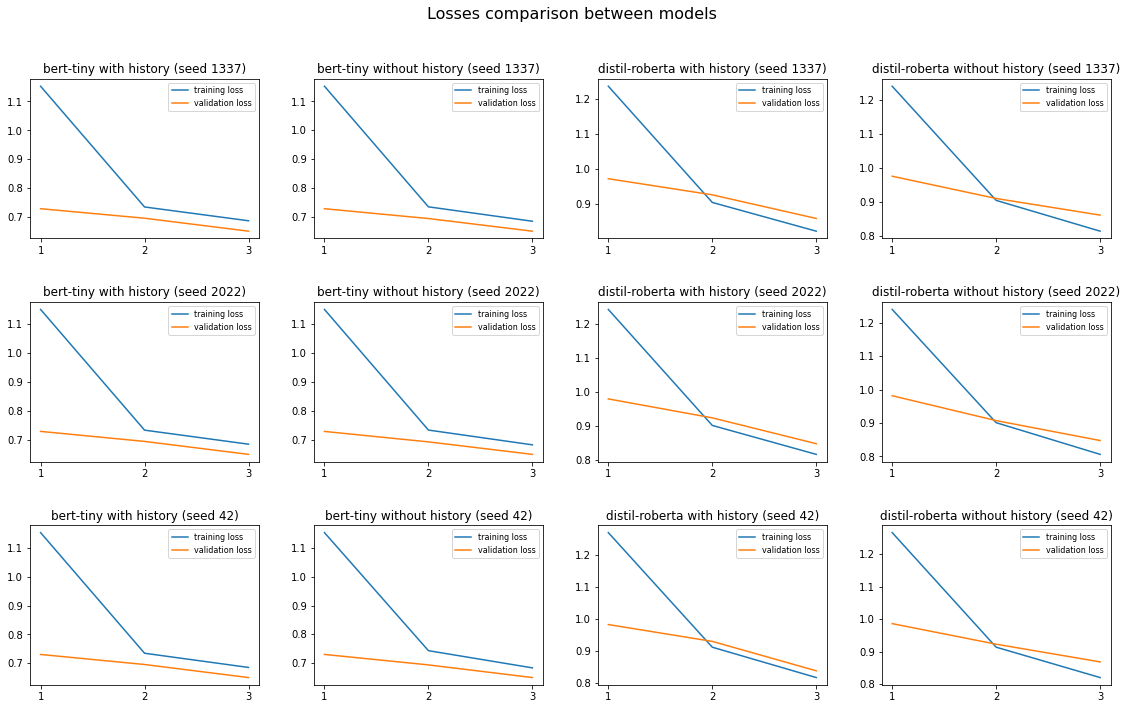

In [ ]:
def plot_grid_losses(df):
    x_values = np.arange(3)+1

    fig, axs = plt.subplots(3, 4, figsize=(16, 10))
    axes = axs.ravel()
    for i, (name, data) in enumerate(df.iterrows()):
        axes[i].plot(x_values, data['train_loss'], label="training loss")
        axes[i].plot(x_values, data['val_loss'], label="validation loss")
        axes[i].set_xticks(x_values)
        mod_name, seed, is_hist = name.split('_', maxsplit=2)
        axes[i].set_title(f"{mod_name} {'with' if is_hist=='hist' else 'without'} history (seed {seed})")
        axes[i].legend(loc="upper right", prop={'size': 8})

    fig.tight_layout()
    fig.subplots_adjust(top=0.88, hspace=0.4)
    fig.suptitle("Losses comparison between models", fontsize="16")
    fig.show()
        
plot_grid_losses(train_data)

As we can see from the charts using distil-roberta there is some overfitting, this is probably due to the higher number of parameters with respect to bert-tiny. Furthermore in order to decrease the computational cost during fine-tuning (and the time needed) we limit the number of samples thus its learning capabilities and the ability to generalize are not exploited at its best.

Considering the different combinations (seed or history) of the same model we cannot notice other particular differences.

### F1 scores

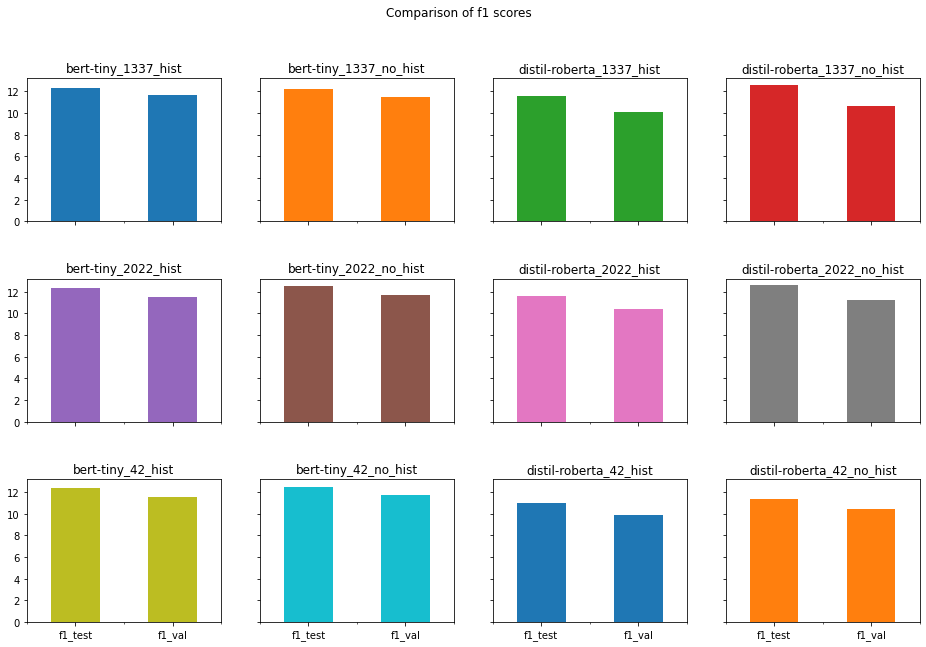

In [ ]:
train_data[['f1_test', 'f1_val']].T.plot(kind='bar',subplots=True, layout=(3, 4), figsize=(16, 10),
                                    sharey=True, title="Comparison of f1 scores",
                                    legend=False, rot=0)
plt.subplots_adjust(top=0.88, hspace=0.4)
plt.xticks=((1,2),('f1_test', 'f1_val'))

In [ ]:
#@title #### funzione di emergenza se non va pandas bar
def plot_grid_f1(df):

    fig, axs = plt.subplots(3, 4, figsize=(16, 10))
    axes = axs.ravel()
    for i, (name, data) in enumerate(df.iterrows()):
        axes[i].plot(x_values, data['train_loss'], label="training loss")
        axes[i].plot(x_values, data['val_loss'], label="validation loss")
        axes[i].set_xticks(x_values)
        mod_name, seed, is_hist = name.split('_', maxsplit=2)
        axes[i].set_title(f"{mod_name} {'with' if is_hist=='hist' else 'without'} history (seed {seed})")
        axes[i].legend(loc="upper right", prop={'size': 8})

    fig.tight_layout()
    fig.subplots_adjust(top=0.88, hspace=0.4)
    fig.suptitle("Losses comparison between models", fontsize="16")
    fig.show()
        
plot_grid_losses(train_data)

We notice that distilroberta models that were trained with the history don't perform well with respect to the others. The f1 scores for these ones are always worse both on test and validation set. 

- In general bert-tiny models have the better f1 scores, probably because we were able to train the models with the entire training dataset and the model is more lightweight.  
- On the other hand distilroberta models struggled when trained with history because the data became more dense of information and given the complexity of the model this affects the learning process.

We decided to do a further test considering the f1 score with beam generation. This should allow the model to creare more sensible answers because it keeps different possibilities for the tokens to choose during the search.

Actually this approach doesn't work very well in our case, with 3 beams the computation is heavy and with 2 beams we were not able to see any improvements in the predicted answers.

Also with sampling method and temperature the predicted answers were not better than the ones produced with the greedy approach.

##### TODO: write a comment on the fact that long answers are worse than shorter ones (mainly distilroberta).

In [ ]:
# Example with the tokenized array without history, I don't know if it can be useful
length = [np.count_nonzero(l) for l in x_test['attention_mask']]
np.mean(length)

345.3837556855101

### Further evaluations

We implemented one function to see the answers that the model gives, on one question or on multiple ones.

In [35]:
#@title ##### Function to test the model manually
def test_model(df: pd.DataFrame, model_name: str, with_history: bool, seed: int, 
               idx_sample: Union[int, List[int]]=88) -> None:
    '''
        This function takes as input the dataframe that contains all the predicted
        answers for the evaluation or test set and it show you some examples of 
        QA.
        Parameters:
            - df: pd.DataFrame
                The dataframe from which we take the questions, answers and the 
                predicted ones.
            - model_name: str
                The name of the model we want to consider.
            - with_history: bool
                If the model used the history.
            - seed: int
                It's the seed the model was trained with.
            - idx_sample: int | list[int]
                If an integer is passed, then the function computes the answer
                for a single sample, otherwise for each sample specified in the
                list (through the index).

        Return:
            The function simply prints the results without returning anything.
    '''
    if isinstance(idx_sample, int):
        idx_sample = [idx_sample]

    # Check if indices are without dataset bounds    
    max_ind = max(idx_sample)
    if max_ind >= len(df):
        print(f"Error: index {max_ind} is out of bounds (dataset of length {len(df)}.")
        return None

    model = get_selected_model(df, model_name, with_history, seed)
    for idx in idx_sample:
        print(f"- The question {idx+1} is:\n\t{model['questions'][idx]}")
        print(f"- The actual answer is:\n\t{model['answers'][idx]}")
        print(f"- The predicted answer is:\n\t{model['predictions'][idx]}\n")

In [ ]:
test_model(df_test_eval, bertiny_name, with_history=True, seed=42, idx_sample=[88, 35, 5200])

#### Compute worst k questions for each source
Given that we had some doubts on the task 7, we decided to implement also a function that compute the worst 5 questions for each source. 

In [106]:
def compute_f1_single_question(df, metric):
    '''
        It returns the f1 score for each sample.
    '''
    # Compute the f1 score for each sample
    pr={'prediction_text':df['predictions'], 'id':str(0)}
    re={'answers': {'text':[df['answers']],'answer_start':[0],},'id':str(0)}

    return metric.compute(predictions=[pr], references=[re])['f1']


def compute_worst_k_questions(df: pd.DataFrame, model_name: str, with_history: bool,
                        seed: int, metric, k=5) -> None:
    '''
        It computes the worst k questions (considering f1 score) for each source.
    '''
    sel_model = get_selected_model(df, model_name, with_history, seed)
    res = sel_model.copy()

    res['f1'] = res.apply(compute_f1_single_question, metric=metric, axis=1)
    res = res.groupby('source').apply(lambda x: x.nsmallest(k, columns=['f1']))
    # To avoid duplicate index
    res = res.drop(columns=['source'])
    print(f"\nThe worst {k} questions for each source are:")
    display(res)
    return res

In [96]:
res = compute_worst_k_questions(df_test_eval, bertiny_name, True, 42, f1_metric)

The model prajjwal1/bert-tiny with the history and seed 42 has been selected.


The worst 5 questions for each source are:


source                                              story  \
source                                                                        
cnn       37         cnn  (CNN) -- Dennis Farina, the dapper, mustachioe...   
          38         cnn  (CNN) -- Dennis Farina, the dapper, mustachioe...   
          39         cnn  (CNN) -- Dennis Farina, the dapper, mustachioe...   
          41         cnn  (CNN) -- Dennis Farina, the dapper, mustachioe...   
          42         cnn  (CNN) -- Dennis Farina, the dapper, mustachioe...   
gutenberg 206  gutenberg  CHAPTER XXII \n\nNorthward, along the leeward ...   
          207  gutenberg  CHAPTER XXII \n\nNorthward, along the leeward ...   
          208  gutenberg  CHAPTER XXII \n\nNorthward, along the leeward ...   
          209  gutenberg  CHAPTER XXII \n\nNorthward, along the leeward ...   
          210  gutenberg  CHAPTER XXII \n\nNorthward, along the leeward ...   
mctest    0       mctest  Once upon a time, in a barn near a farm house,...   
          1       mctest  Once upon a time, in a barn near a farm house,...   
          2       mctest  Once upon a time, in a barn near a farm house,...   
          3       mctest  Once upon a time, in a barn near a farm house,...   
          4       mctest  Once upon a time, in a barn near a farm house,...   
race      21        race  My doorbell rings. On the step, I find the eld...   
          23        race  My doorbell rings. On the step, I find the eld...   
          25        race  My doorbell rings. On the step, I find the eld...   
          26        race  My doorbell rings. On the step, I find the eld...   
          27        race  My doorbell rings. On the step, I find the eld...   
wikipedia 73   wikipedia  Staten Island is one of the five boroughs of N...   
          74   wikipedia  Staten Island is one of the five boroughs of N...   
          75   wikipedia  Staten Island is one of the five boroughs of N...   
          77   wikipedia  Staten Island is one of the five boroughs of N...   
          78   wikipedia  Staten Island is one of the five boroughs of N...   

                                                       questions  \
source                                                             
cnn       37                                               Whom?   
          38                                     What did he do?   
          39                                  Is he still alive?   
          41                                    Anything recent?   
          42                    What happened in the early 80's?   
gutenberg 206                     What worked her way northward?   
          207  What lay between the shore-reefs and outer-reefs?   
          208                            Were the passages wide?   
          209                               Who was the Captain?   
          210                              Did he have red hair?   
mctest    0                               What color was Cotton?   
          1                                  Where did she live?   
          2                                  Did she live alone?   
          3                               Who did she live with?   
          4                         What color were her sisters?   
race      21                                 Who is at the door?   
          23                                               What?   
          25                                Who is her daughter?   
          26                             Where does Nicole live?   
          27                      How is she related to the boy?   
wikipedia 73                       How many burroughs are there?   
          74                                       in what city?   
          75                                          and state?   
          77                                        Where is it?   
          78                  What separates it from new jersey?   

                                               

# Assignment Evaluation

The following assignment points will be awarded for each task as follows:

* Task 1, Pre-processing $\rightarrow$ 0.5 points.
* Task 2, Dataset Splitting $\rightarrow$ 0.5 points.
* Task 3 and 4, Models Definition $\rightarrow$ 1.0 points.
* Task 5 and 6, Models Training and Evaluation $\rightarrow$ 2.0 points.
* Task 7, Analysis $\rightarrow$ 1.0 points.
* Report $\rightarrow$ 1.0 points.

**Total** = 6 points <br>

We may award an additional 0.5 points for outstanding submissions. 
 
**Speed Bonus** = 0.5 extra points <br>

## Report

We apply the rules described in Assignment 1 regarding the report.
* Write a clear and concise report following the given overleaf template (**max 2 pages**).
* Report validation and test results in a table.$^1$
* **Avoid reporting** code snippets or copy-paste terminal outputs $\rightarrow$ **Provide a clean schema** of what you want to show

## Comments and Organization

Remember to properly comment your code (it is not necessary to comment each single line) and don't forget to describe your work!

Structure your code for readability and maintenance. If you work with Colab, use sections. 

This allows you to build clean and modular code, as well as easy to read and to debug (notebooks can be quite tricky time to time).

## FAQ (READ THIS!)

---

**Question**: Does Task 3 also include data tokenization and conversion step?

**Answer:** Yes! These steps are usually straightforward since ```transformers``` also offers a specific tokenizer for each model.

**Example**: 

```
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
encoded_text = tokenizer(text)
%% Alternatively
inputs = tokenizer.tokenize(text, add_special_tokens=True, max_length=min(max_length, 512))
input_ids, attention_mask = inputs['input_ids'], inputs['attention_mask']
```

**Suggestion**: Hugginface's documentation is full of tutorials and user-friendly APIs.

---
---

**Question**: I'm hitting **out of memory error** when training my models, do you have any suggestions?

**Answer**: Here are some common workarounds:

1. Try decreasing the mini-batch size
2. Try applying a different padding strategy (if you are applying padding): e.g. use quantiles instead of maximum sequence length

---
---

## Contact

For any doubt, question, issue or help, you can always contact us at the following email addresses:

Teaching Assistants:

* Andrea Galassi -> a.galassi@unibo.it
* Federico Ruggeri -> federico.ruggeri6@unibo.it

Professor:

* Paolo Torroni -> p.torroni@unibo.it

## The End!

Questions?